In [1]:
import dask
import dask_awkward as dak
from coffea.dataset_tools import preprocess
from distributed import Client
from matplotlib import pyplot as plt

import egamma_tnp
from egamma_tnp import ElectronTagNProbeFromNanoAOD, ElectronTagNProbeFromNTuples
from egamma_tnp.plot import plot_efficiency

/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/coffea/lookup_tools/evaluator.py:7: FutureWarning: In version 2024.8.0 (target date: 2024-07-31 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.lookup_tools.json_lookup will be removed by August 2024. Please use lumi_tools or correctionlib instead!.
  from coffea.lookup_tools.json_lookup import json_lookup


In [2]:
client = Client()

2024-07-04 19:02:28,025 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p1084'}, 'attr': 'inner_width', 'new': 489}, {'kind': 'ModelChanged', 'model': {'id': 'p1084'}, 'attr': 'inner_height', 'new': 390}, {'kind': 'ModelChanged', 'model': {'id': 'p1084'}, 'attr': 'outer_width', 'new': 509}, {'kind': 'ModelChanged', 'model': {'id': 'p1084'}, 'attr': 'outer_height', 'new': 470}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 97, in handle
    work = await handler(message, connection)
  File "/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/Users/iason/miniforge3/envs/egamma_dev/lib/python3.10/site-packages/bokeh/s

In [3]:
filters_to_check = [
    "hltEG30L1SingleEGOrEtFilter",
    "hltEle30WPTightClusterShapeFilter",
    "hltEle30WPTightHEFilter",
    "hltEle30WPTightEcalIsoFilter",
    "hltEle30WPTightHcalIsoFilter",
    "hltEle30WPTightPixelMatchFilter",
    "hltEle30WPTightPMS2Filter",
    "hltEle30WPTightGsfOneOEMinusOneOPFilter",
    "hltEle30WPTightGsfMissingHitsFilter",
    "hltEle30WPTightGsfDetaFilter",
    "hltEle30WPTightGsfDphiFilter",
    "hltEle30WPTightGsfTrackIsoFilter",
]

In [4]:
fileset = {
    "data_EGamma_Run2024Ev2": {
        "files": {
            "tnptuples/data_EGamma0_Run2024Ev2.root": "tnpEleTrig/fitter_tree",
            "tnptuples/data_EGamma1_Run2024Ev2.root": "tnpEleTrig/fitter_tree",
        },
    },
    "data_EGamma_Run2024F": {
        "files": {
            "tnptuples/data_EGamma0_Run2024F.root": "tnpEleTrig/fitter_tree",
            "tnptuples/data_EGamma1_Run2024F.root": "tnpEleTrig/fitter_tree",
        },
    },
}

fileset_available, fileset_updated = preprocess(fileset, step_size=500_000, skip_bad_files=True)

In [5]:
egamma_tnp.binning.set(
    "pt_bins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

to_compute = {}

tnp = ElectronTagNProbeFromNTuples(
    fileset_available,
    [f"pass{filter.replace('hlt', 'HLT')}" for filter in filters_to_check],
    use_sc_eta=False,
    probes_pt_cut=5,
    cutbased_id="passingCutBasedTight122XV1",
)

for filter in filters_to_check:
    to_compute[filter] = tnp.get_1d_pt_eta_phi_tnp_histograms(
        f"pass{filter.replace('hlt', 'HLT')}",
        vars=["el_pt", "el_sc_eta", "el_sc_phi"],
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=35,
        uproot_options={"allow_read_errors_with_report": False},
    )

dak.necessary_columns(to_compute)

{'from-uproot-9600a2fa5c3190768b65365351600274': frozenset({'el_eta',
            'el_pt',
            'el_q',
            'el_sc_eta',
            'el_sc_phi',
            'pair_mass',
            'passHLTEG30L1SingleEGOrEtFilter',
            'passHLTEle30WPTightClusterShapeFilter',
            'passHLTEle30WPTightEcalIsoFilter',
            'passHLTEle30WPTightGsfDetaFilter',
            'passHLTEle30WPTightGsfDphiFilter',
            'passHLTEle30WPTightGsfMissingHitsFilter',
            'passHLTEle30WPTightGsfOneOEMinusOneOPFilter',
            'passHLTEle30WPTightGsfTrackIsoFilter',
            'passHLTEle30WPTightHEFilter',
            'passHLTEle30WPTightHcalIsoFilter',
            'passHLTEle30WPTightPMS2Filter',
            'passHLTEle30WPTightPixelMatchFilter',
            'passingCutBasedTight122XV1',
            'tag_Ele_eta',
            'tag_Ele_pt',
            'tag_Ele_q'}),
 'from-uproot-3da57b1067872a504085654428b3c457': frozenset({'el_eta',
            'el_pt',
    

In [6]:
%%time

(out,) = dask.compute(to_compute)

CPU times: user 9.51 s, sys: 389 ms, total: 9.9 s
Wall time: 14.2 s


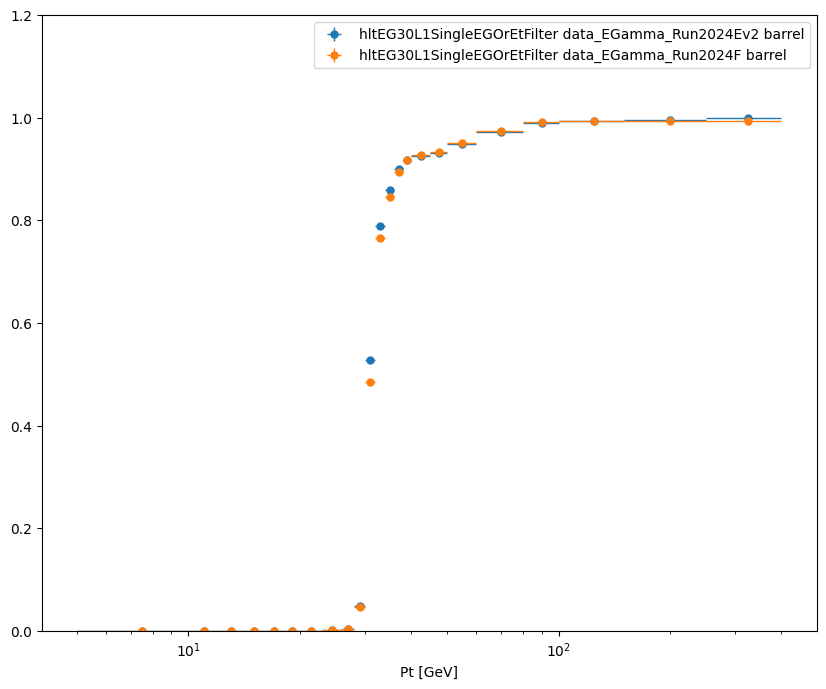

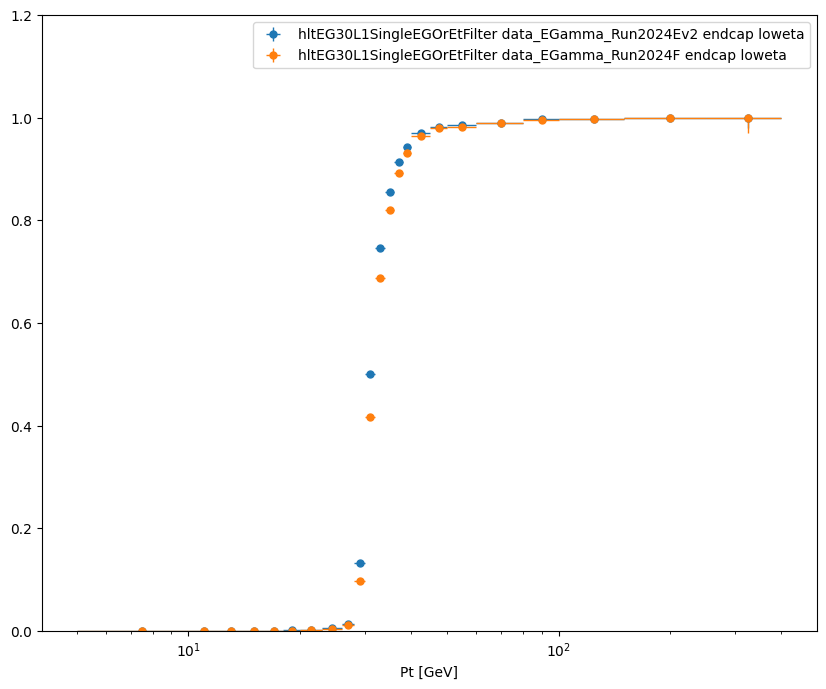

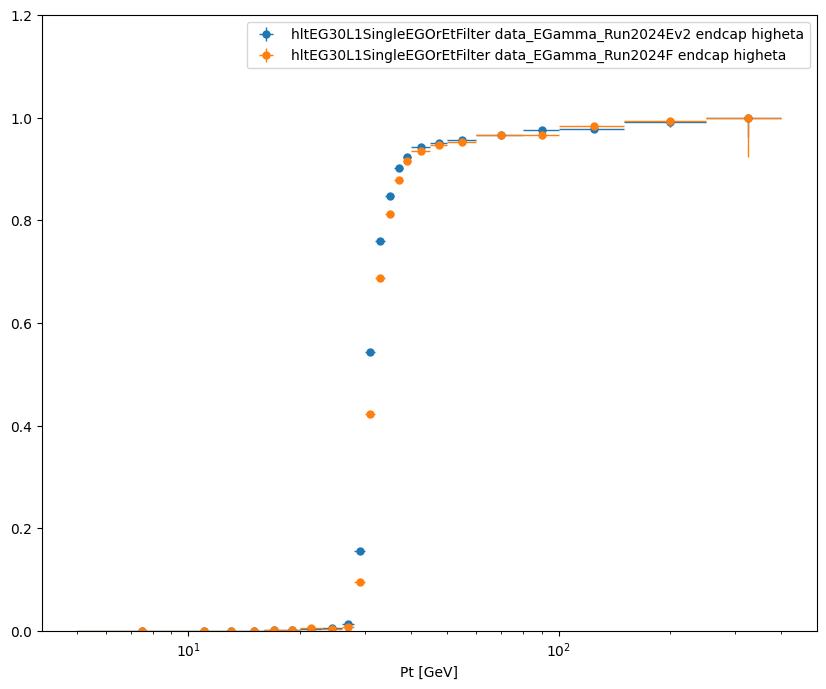

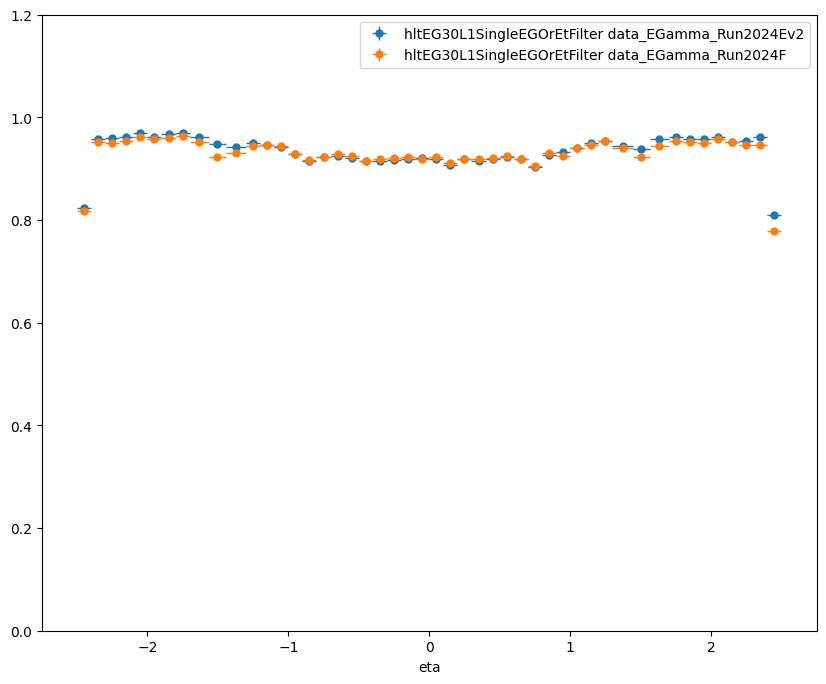

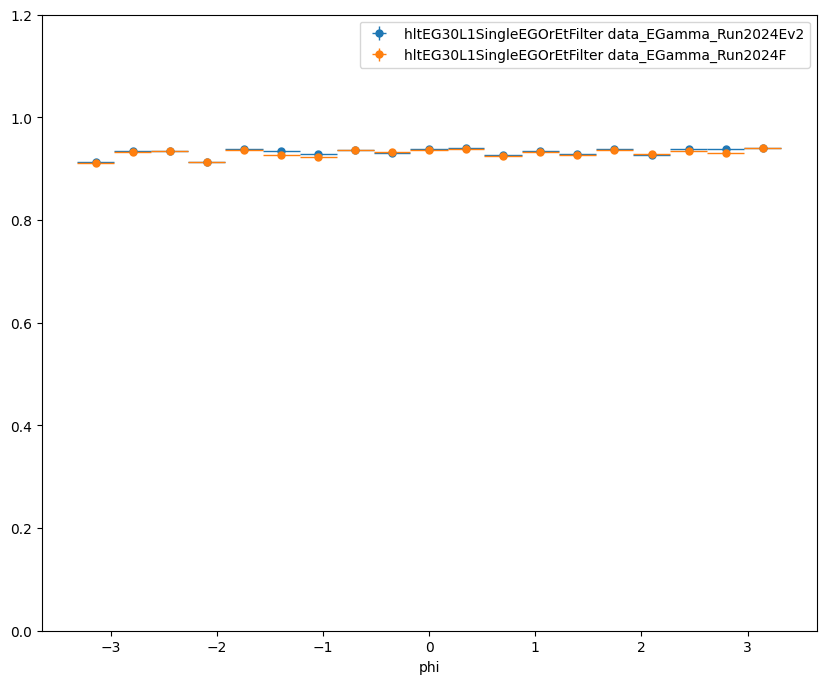

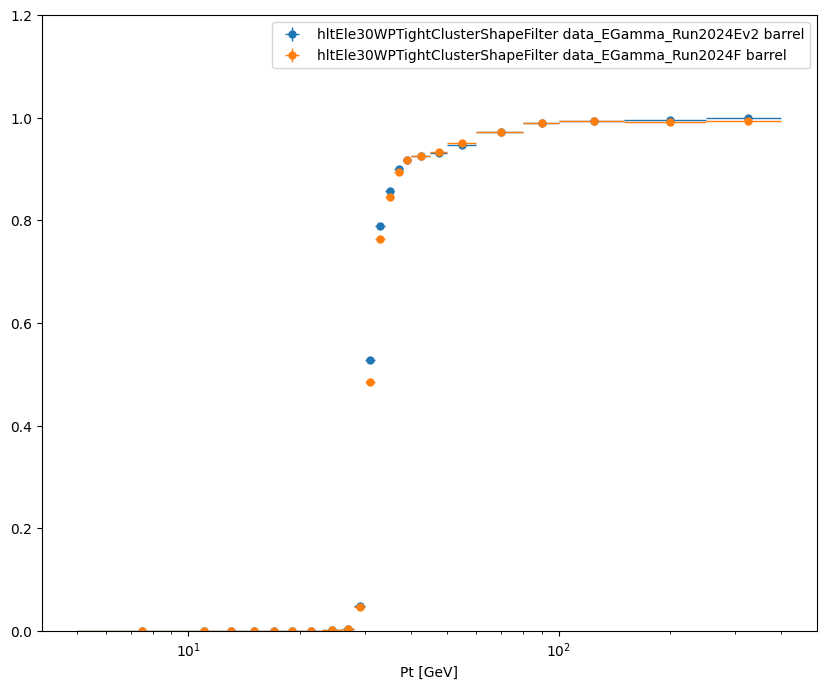

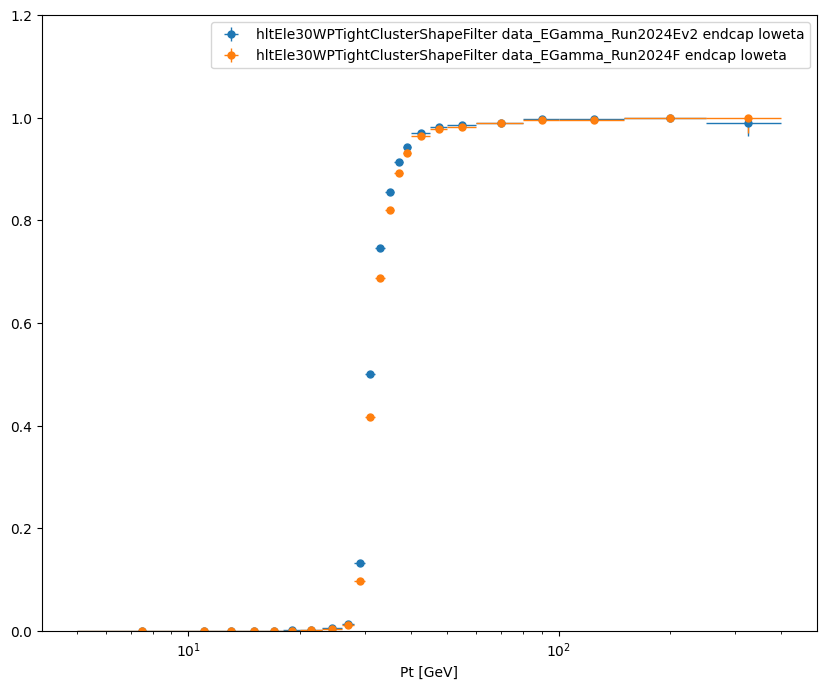

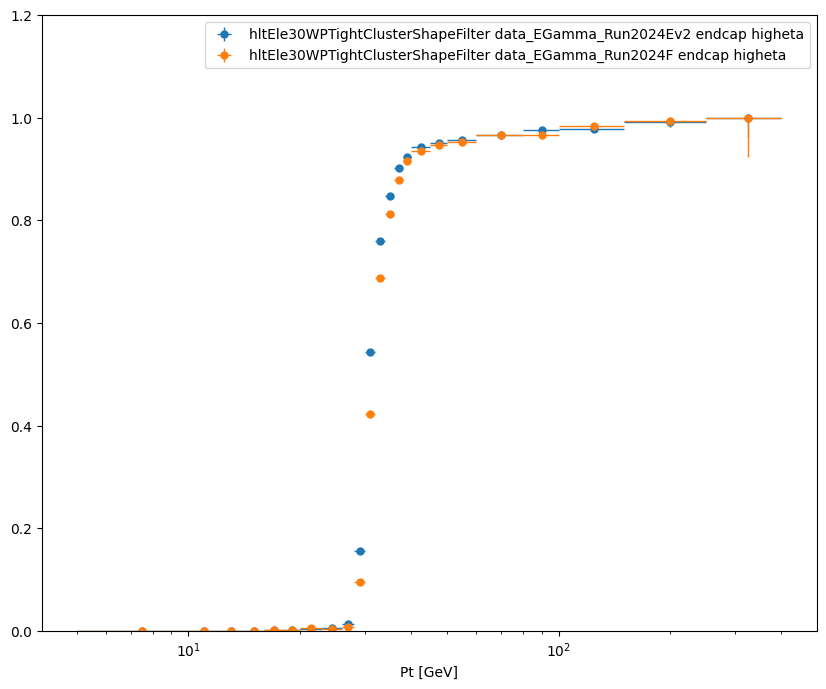

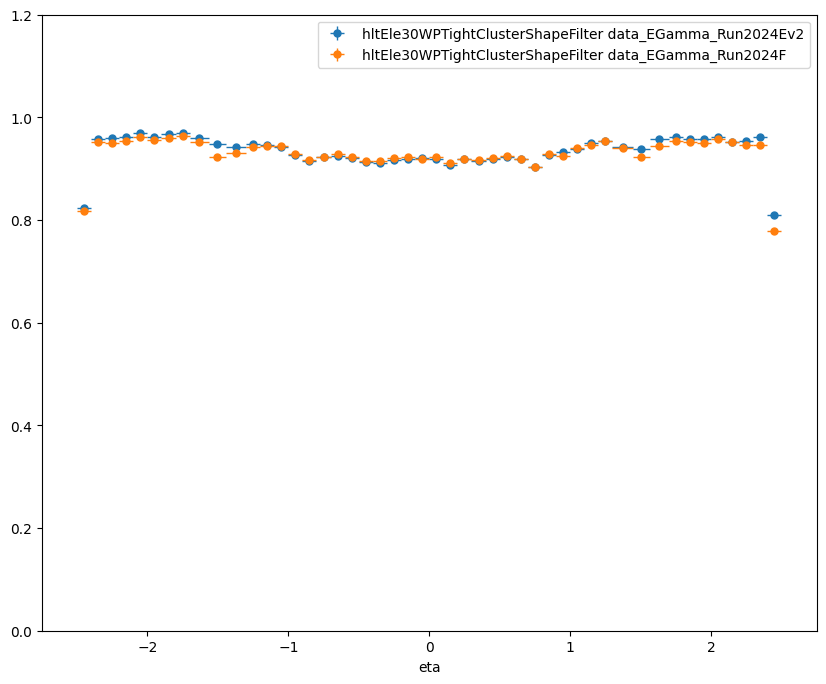

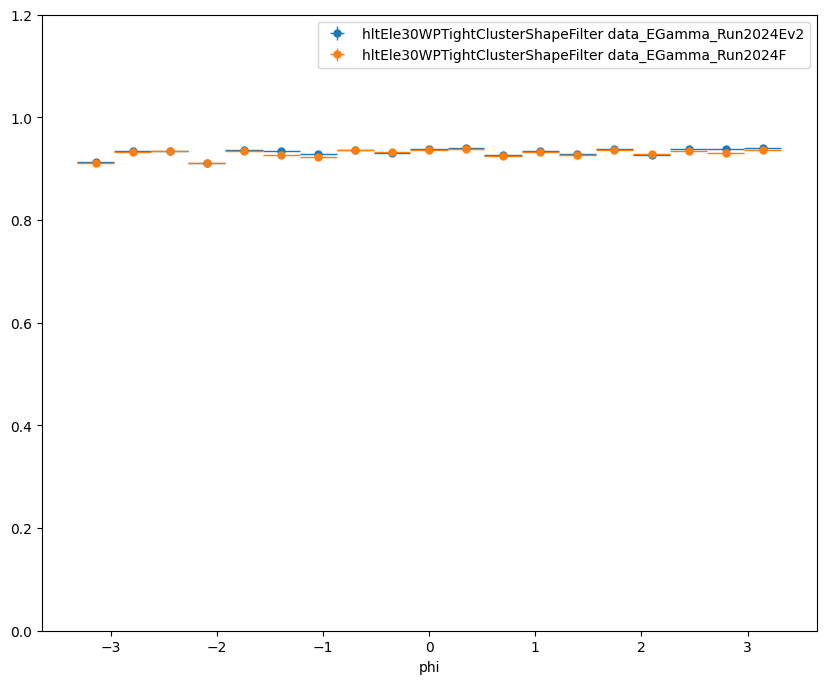

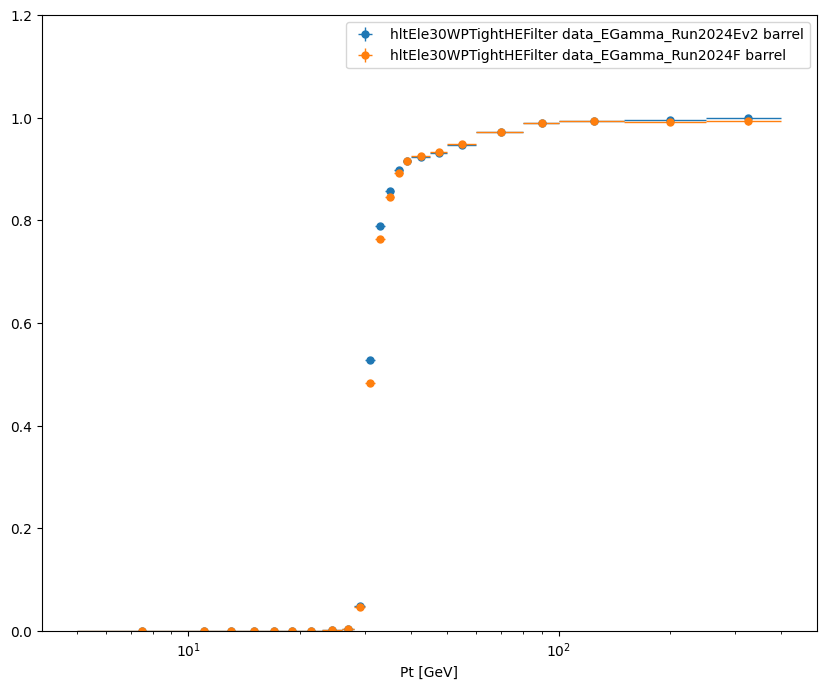

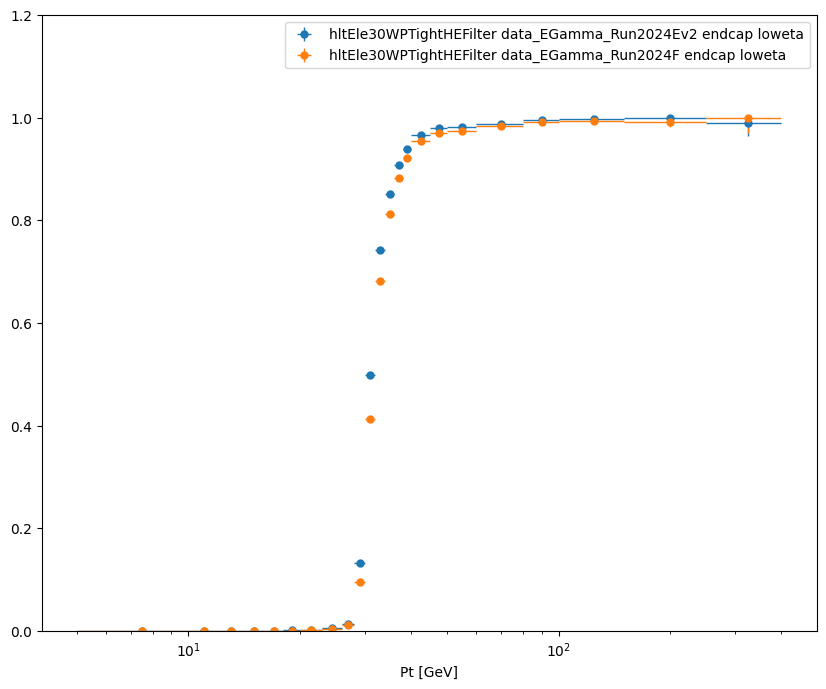

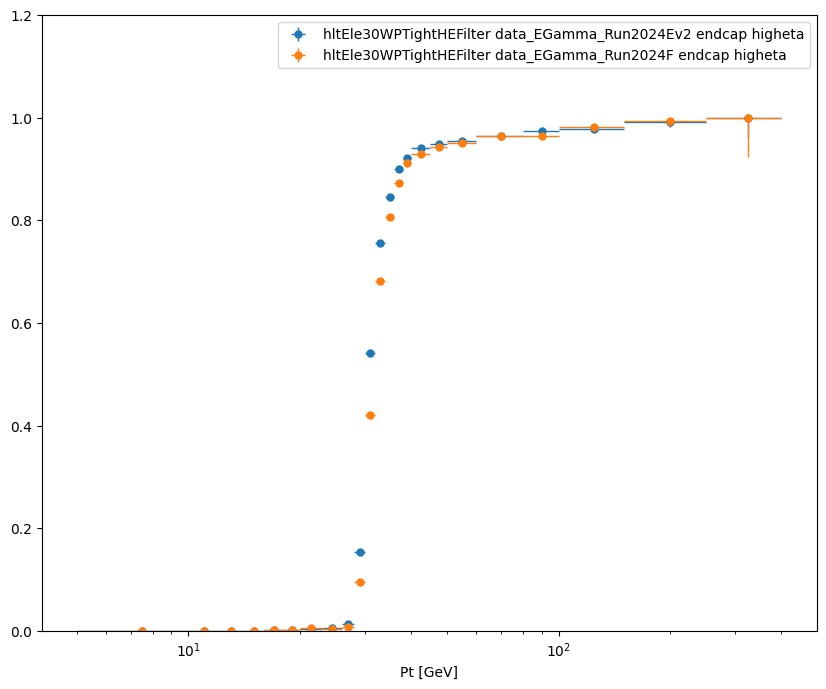

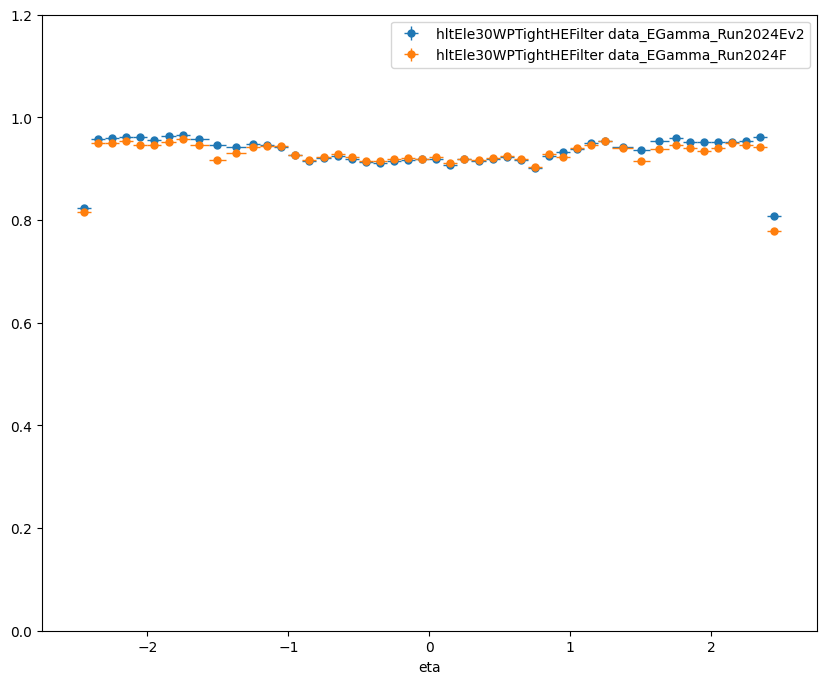

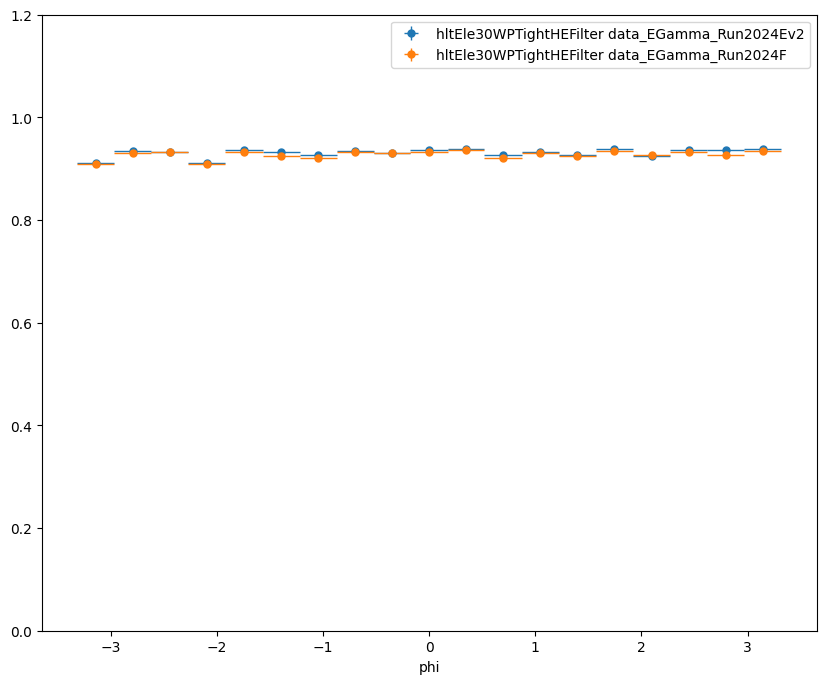

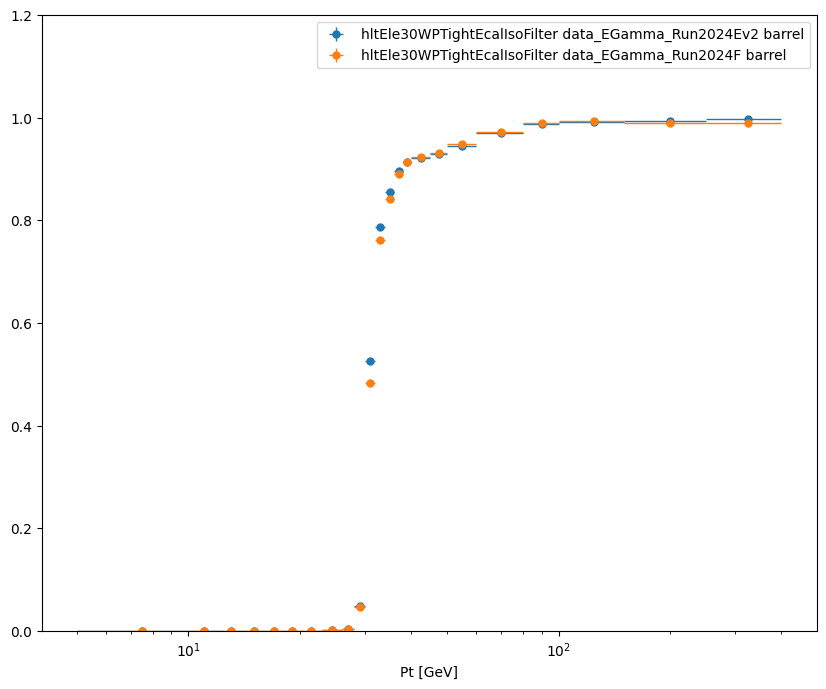

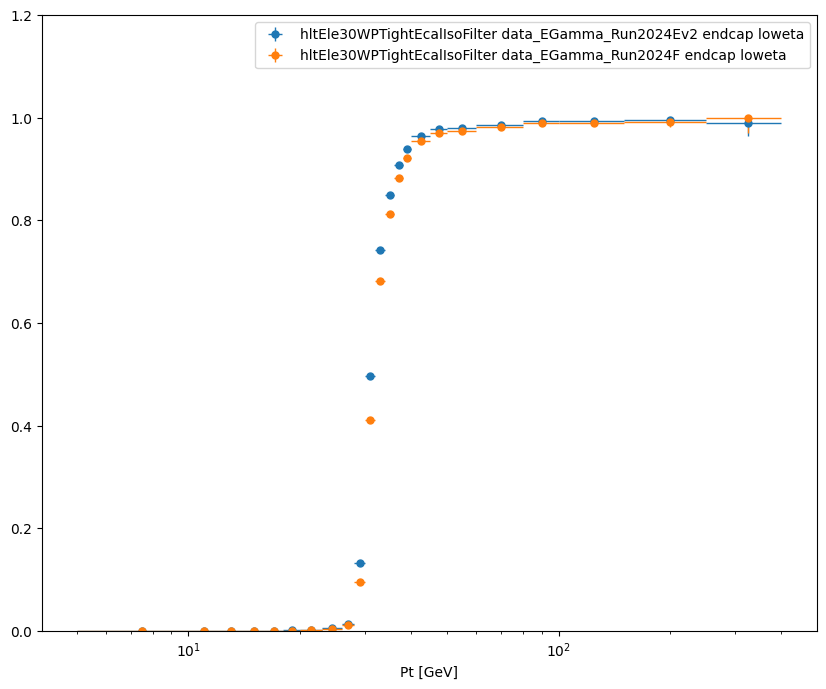

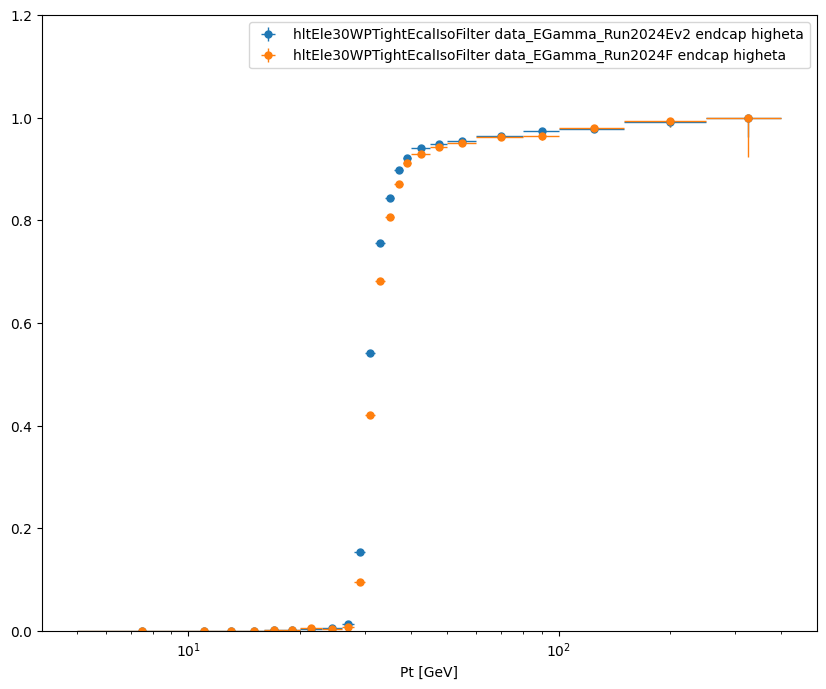

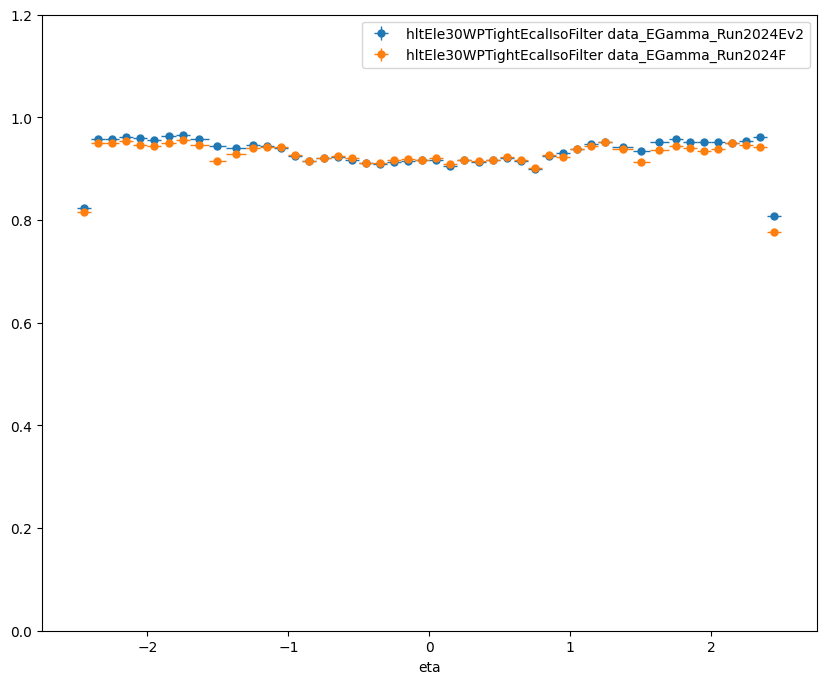

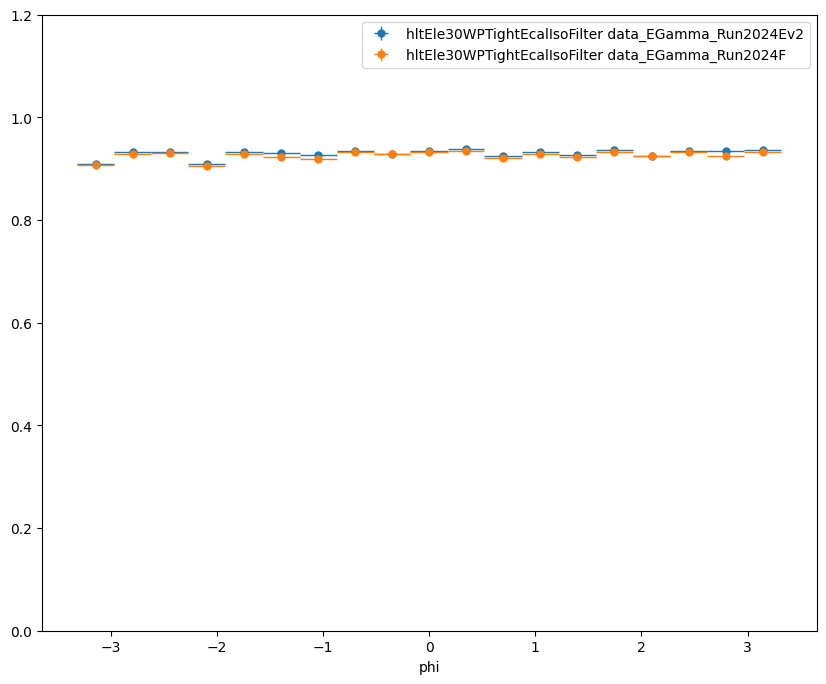

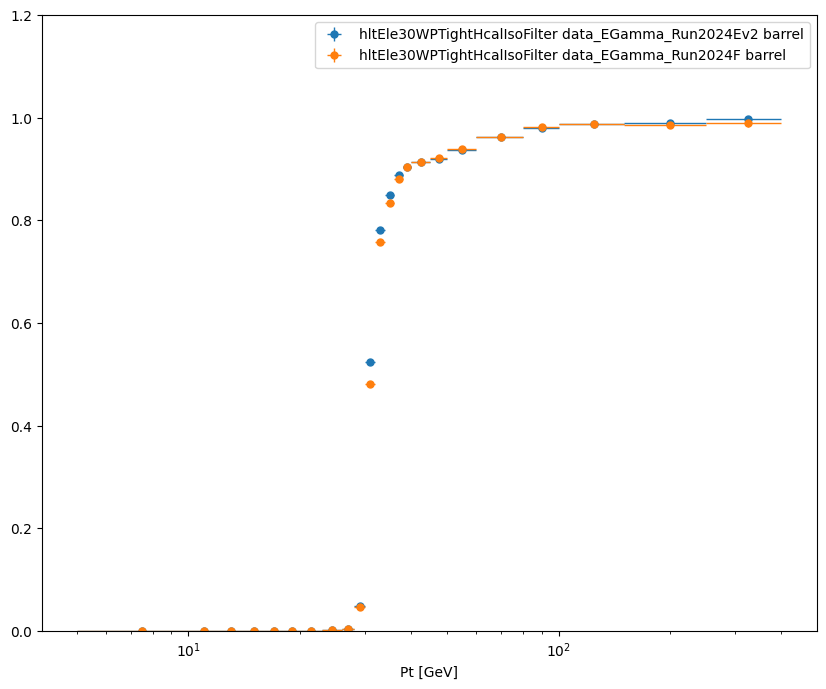

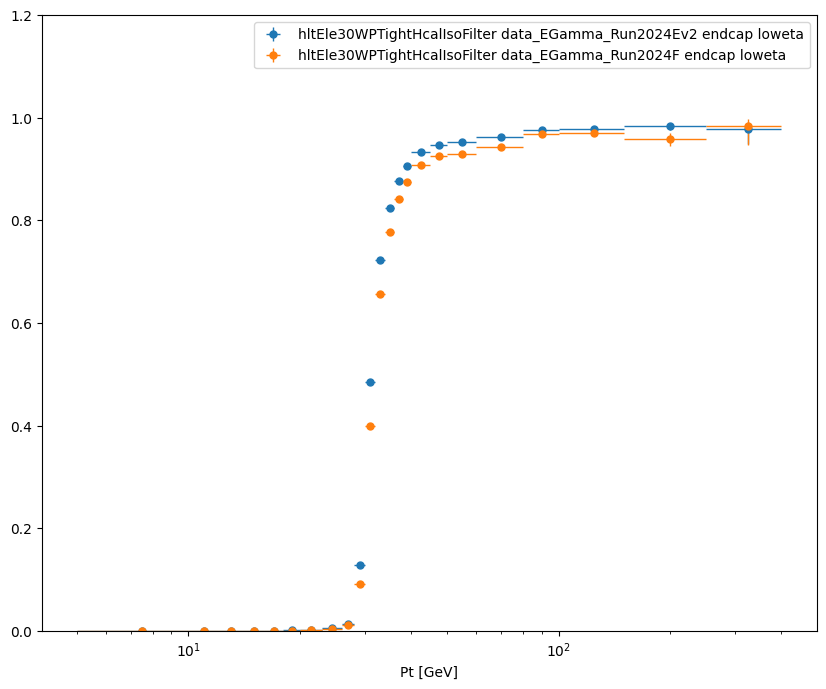

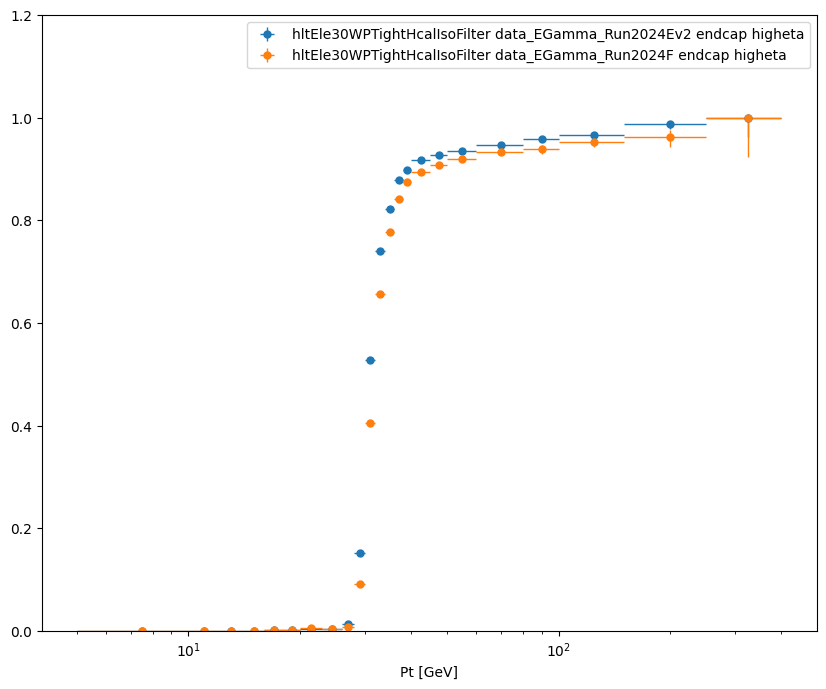

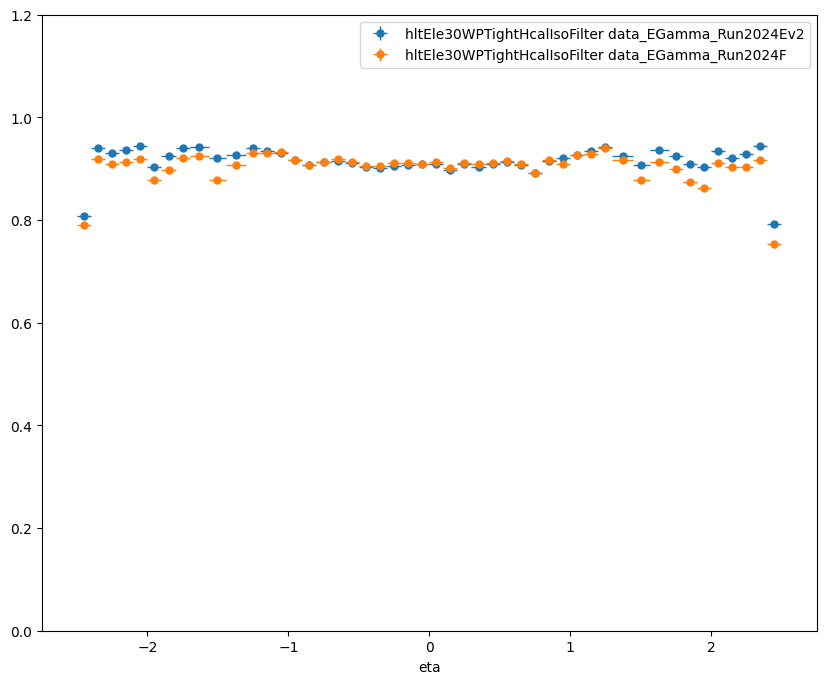

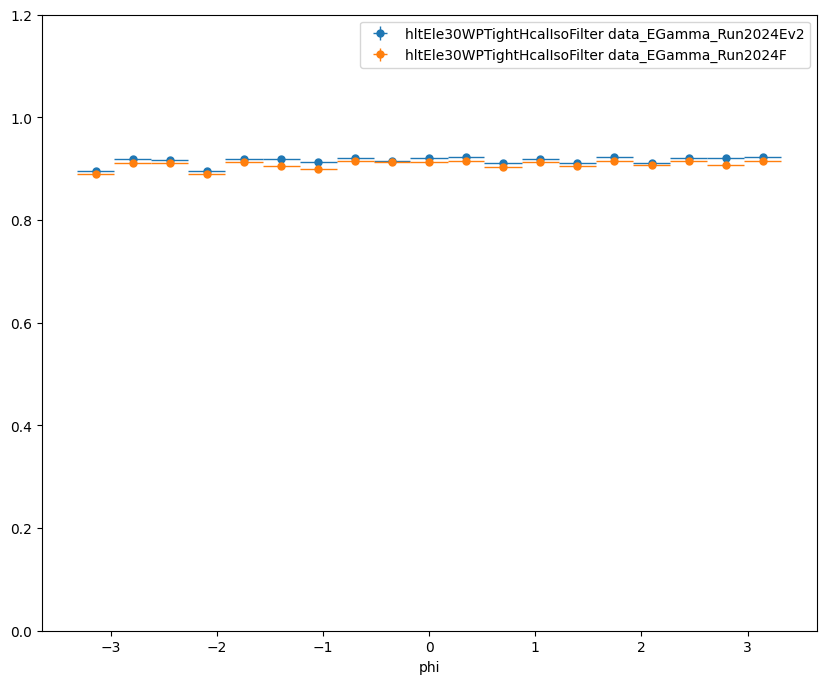

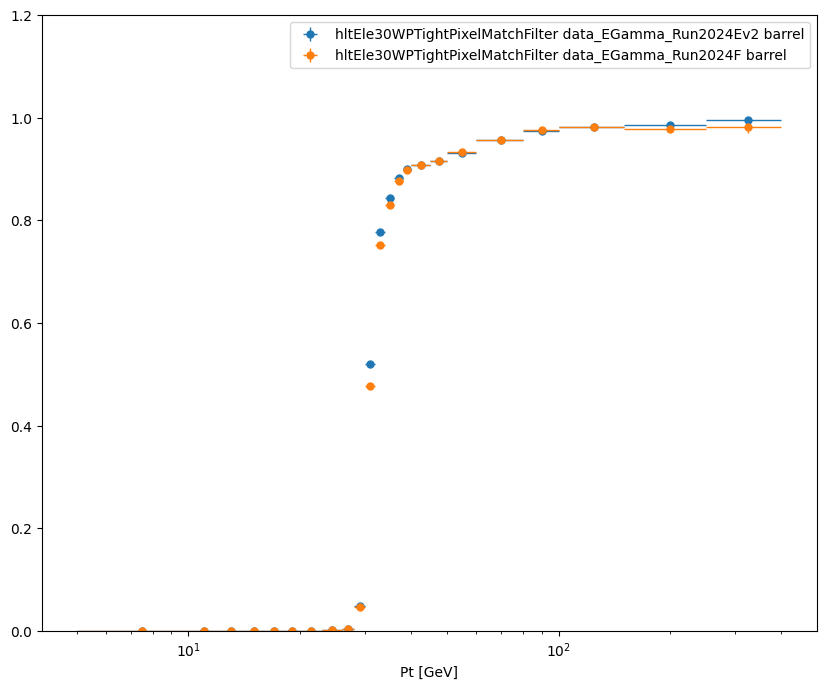

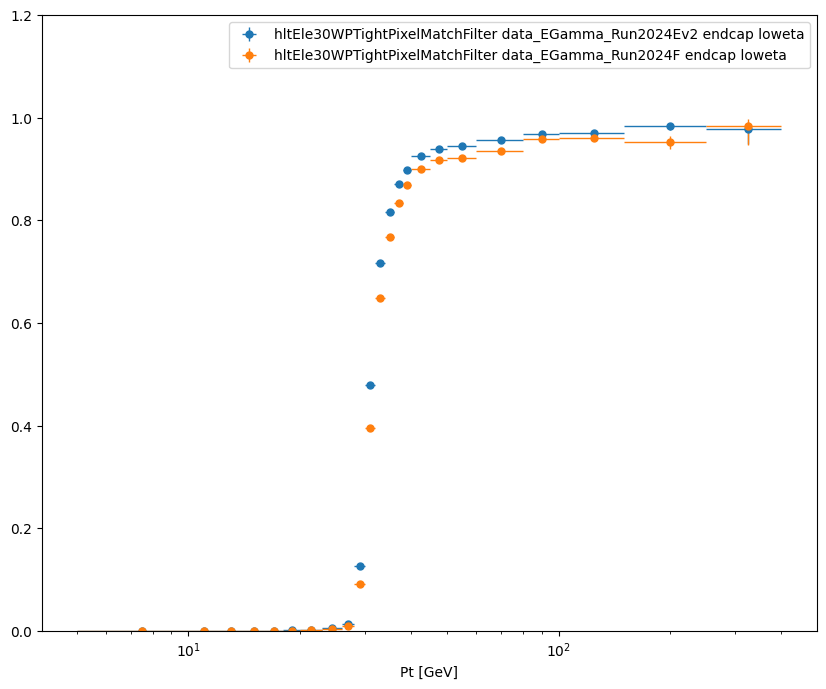

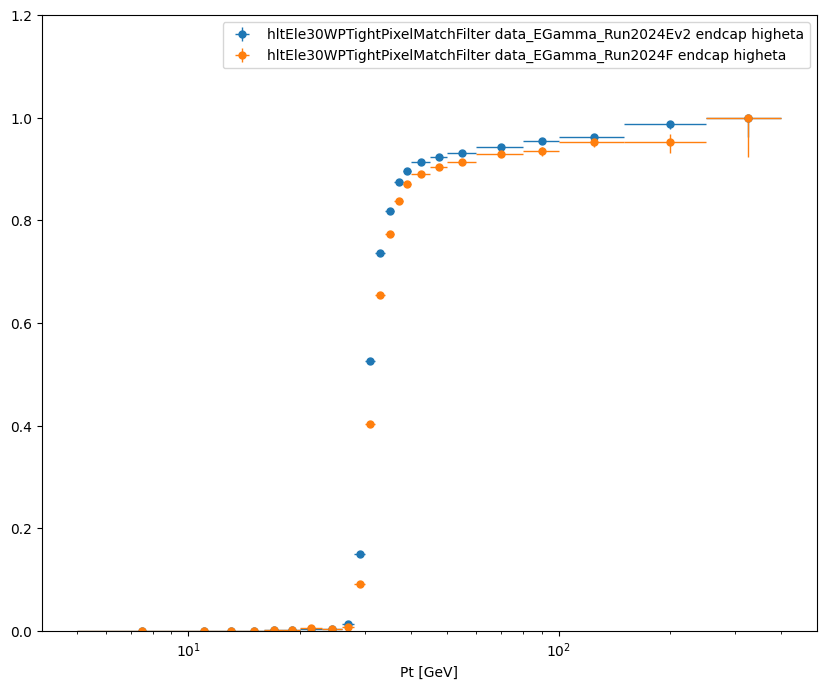

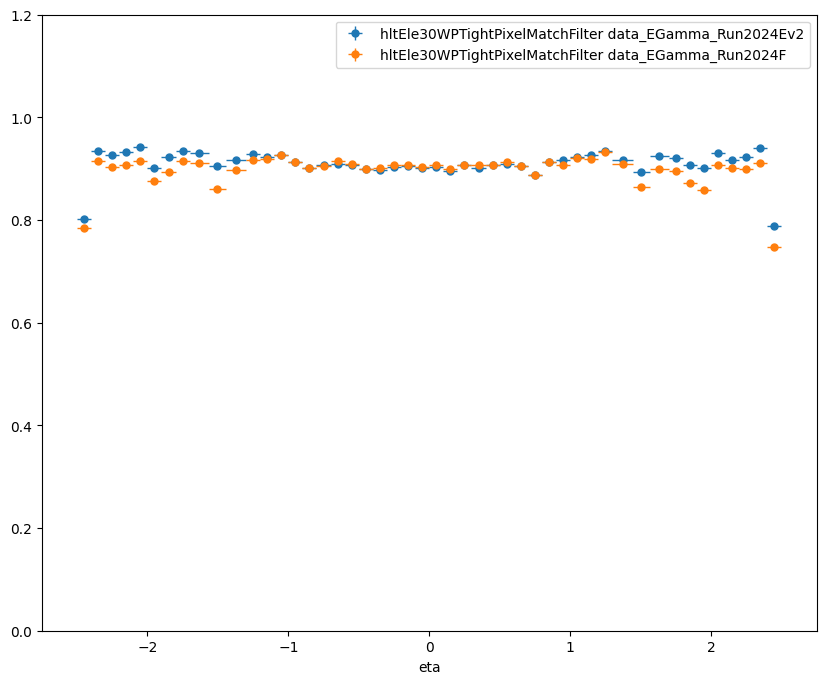

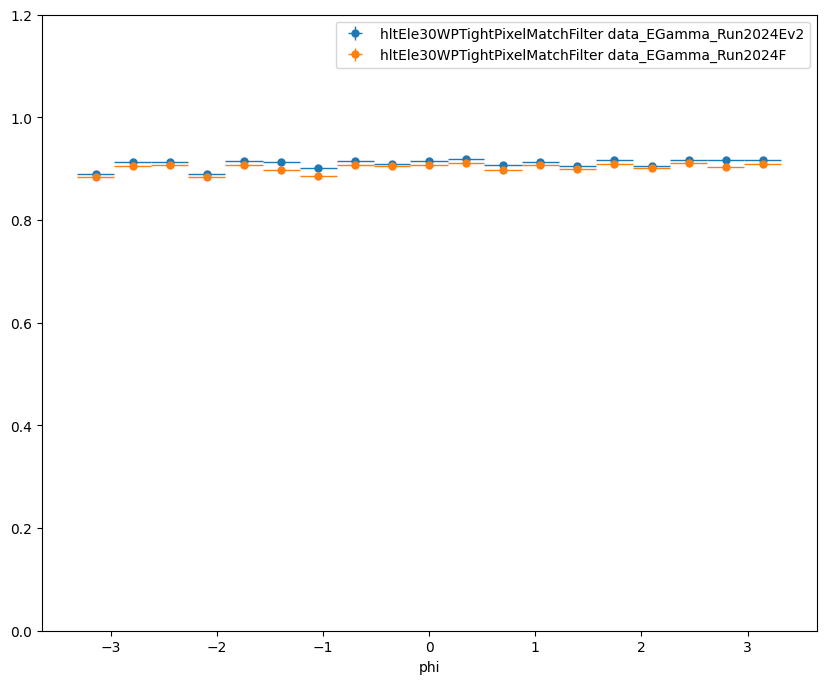

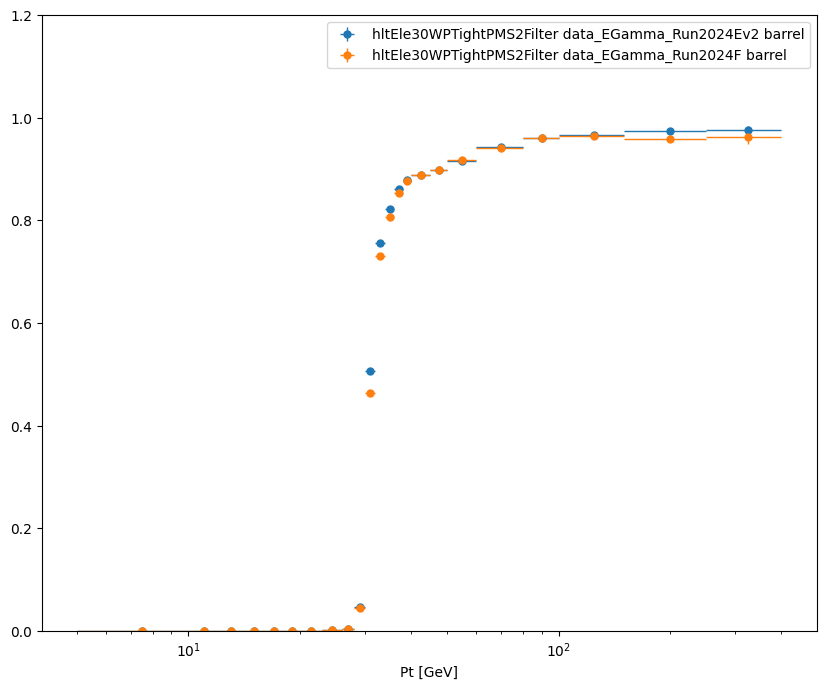

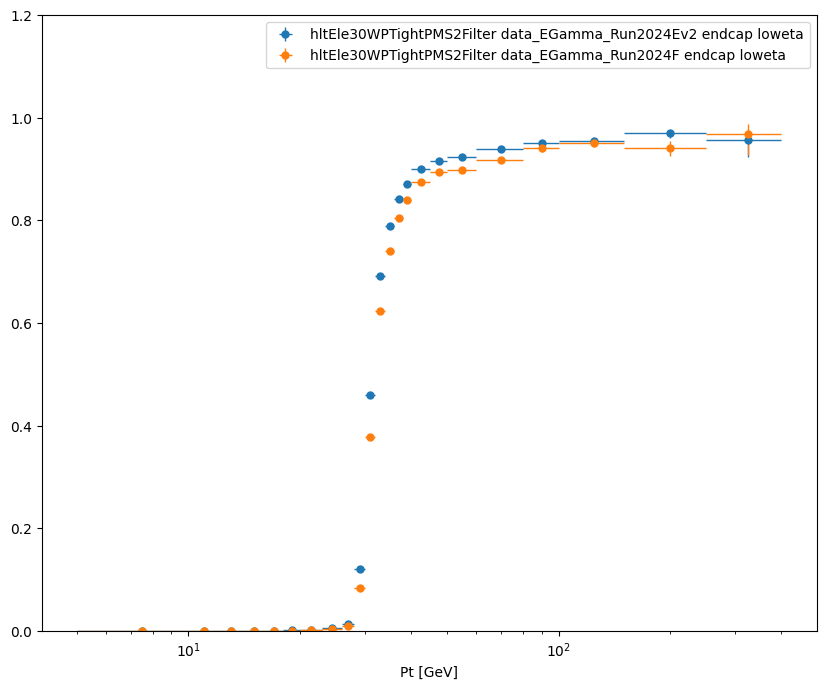

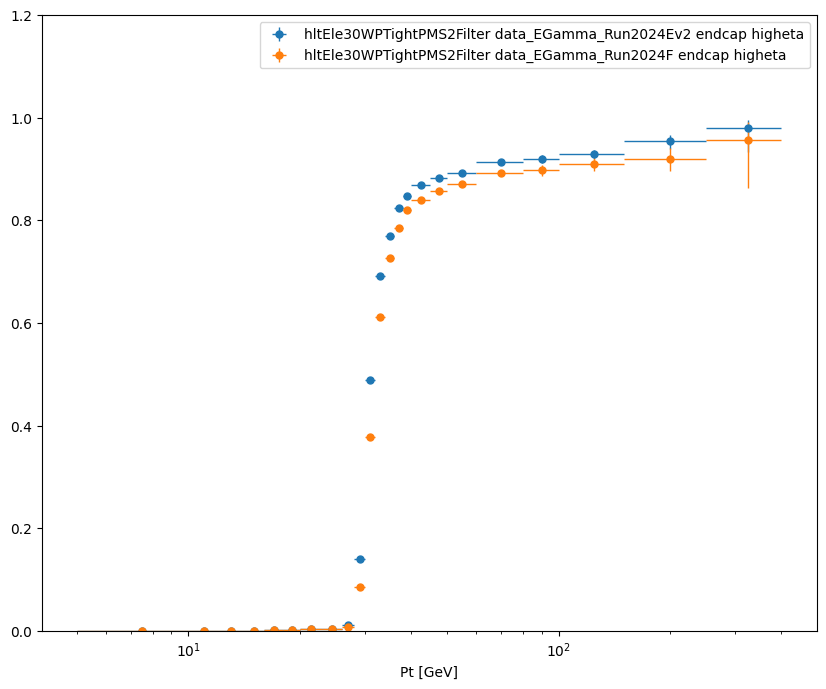

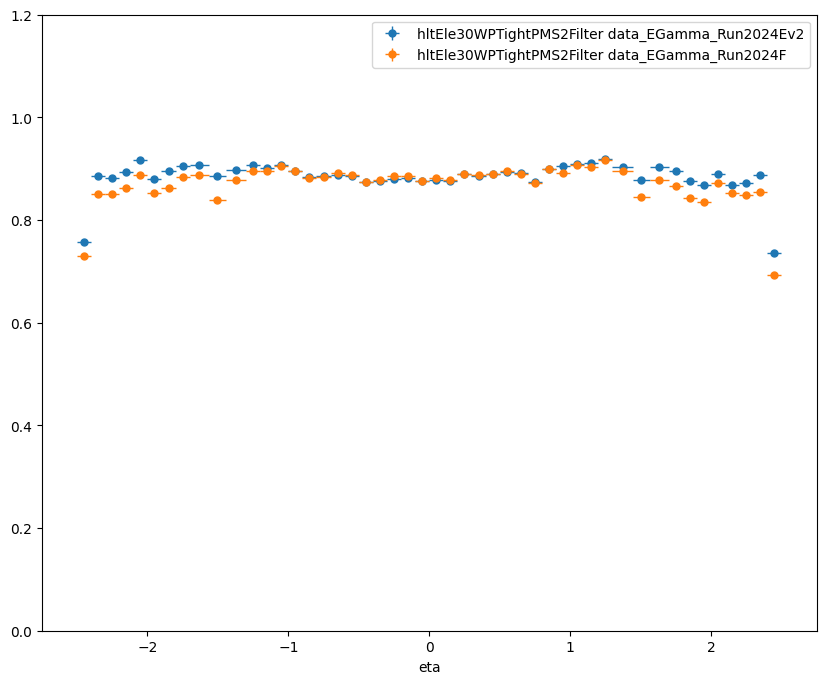

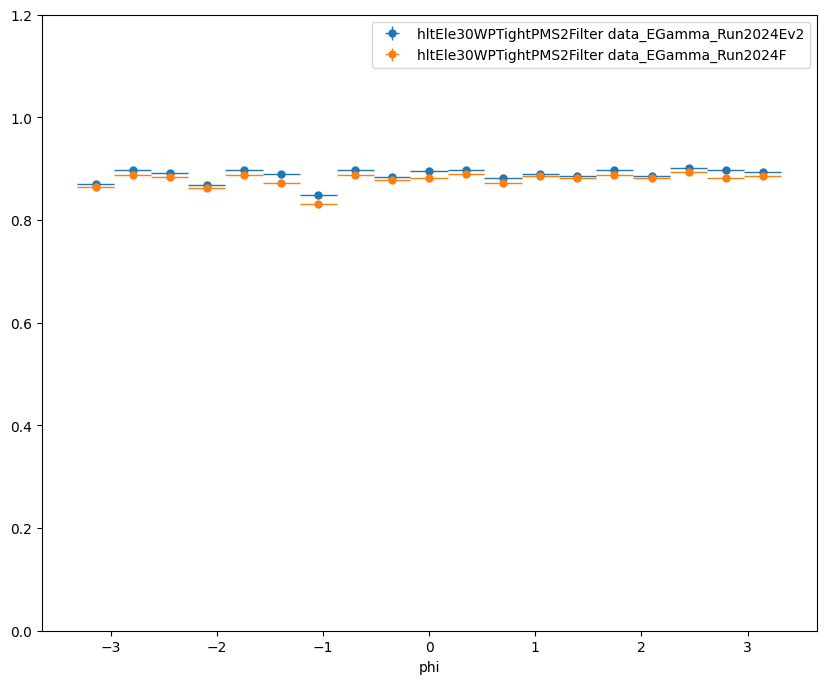

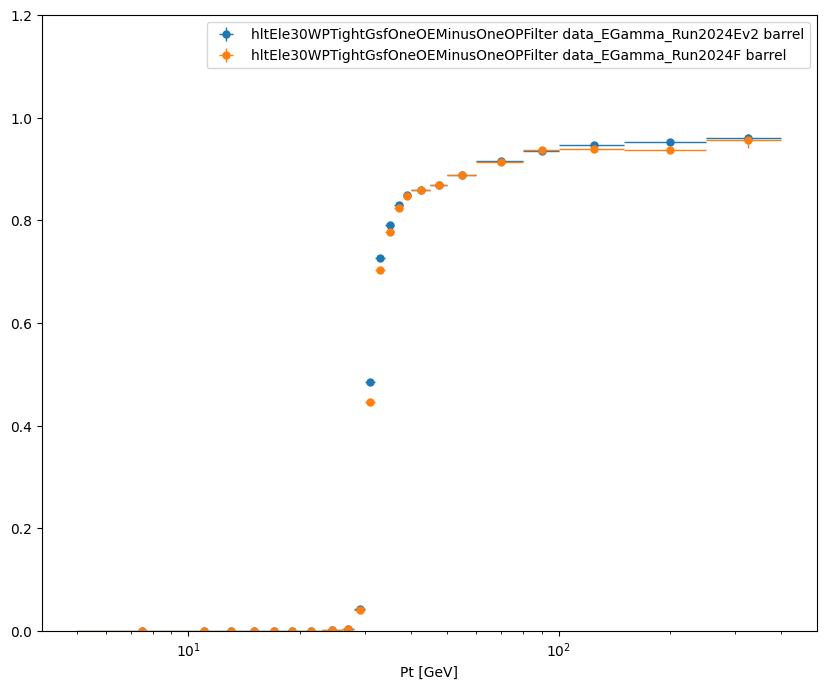

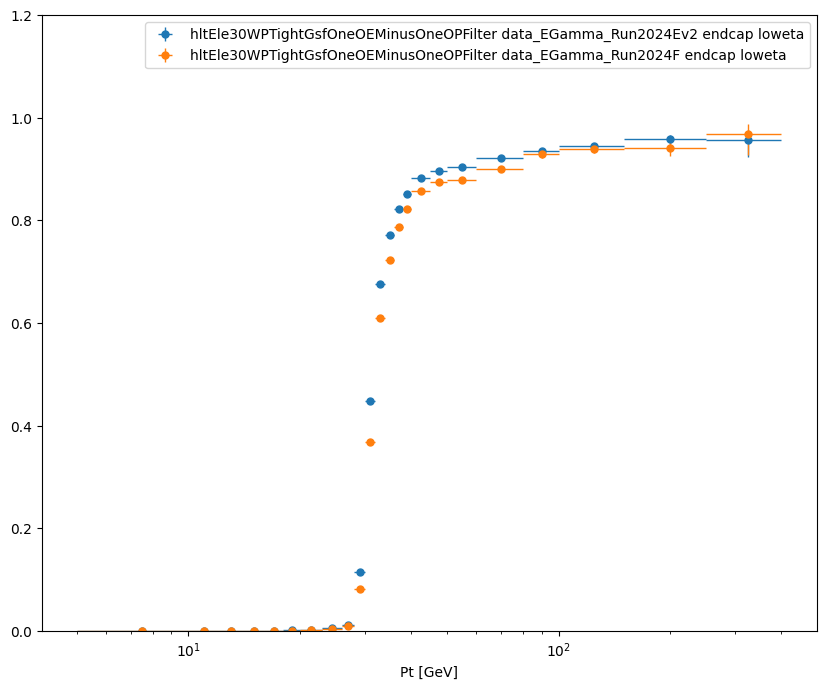

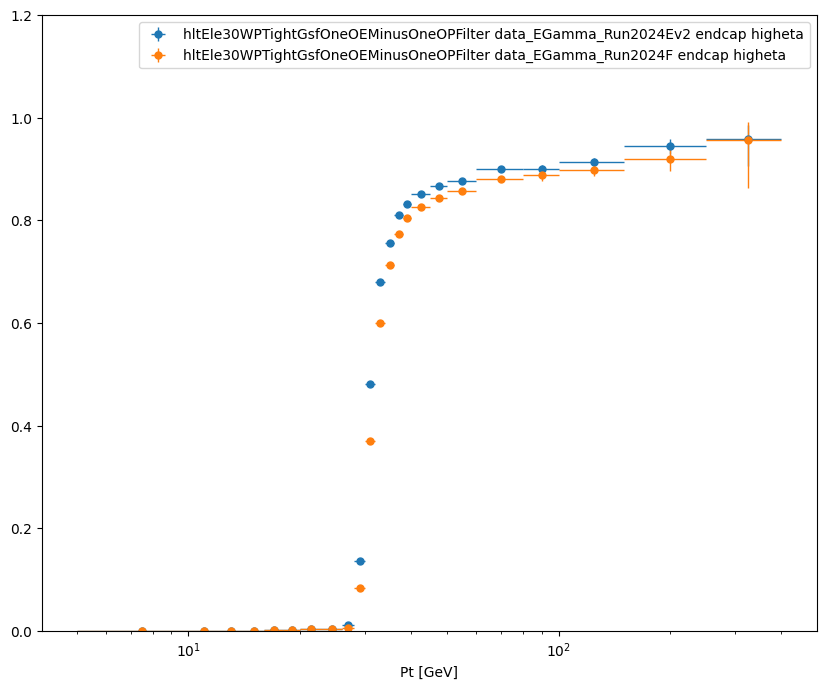

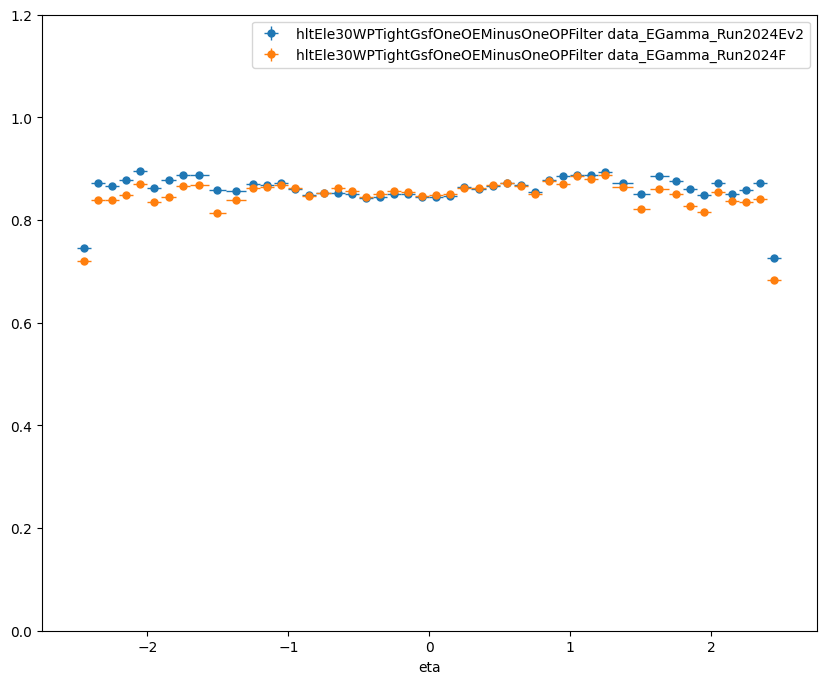

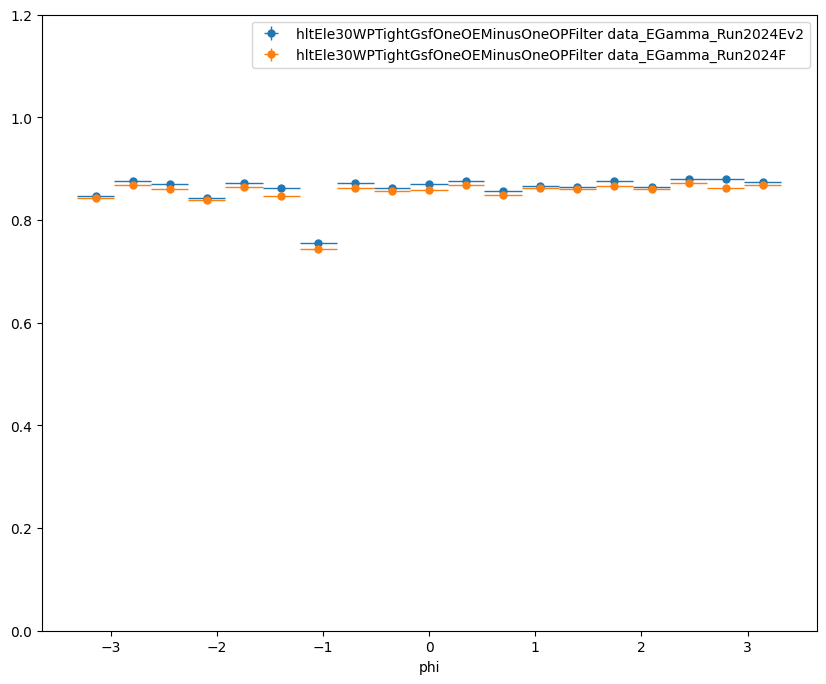

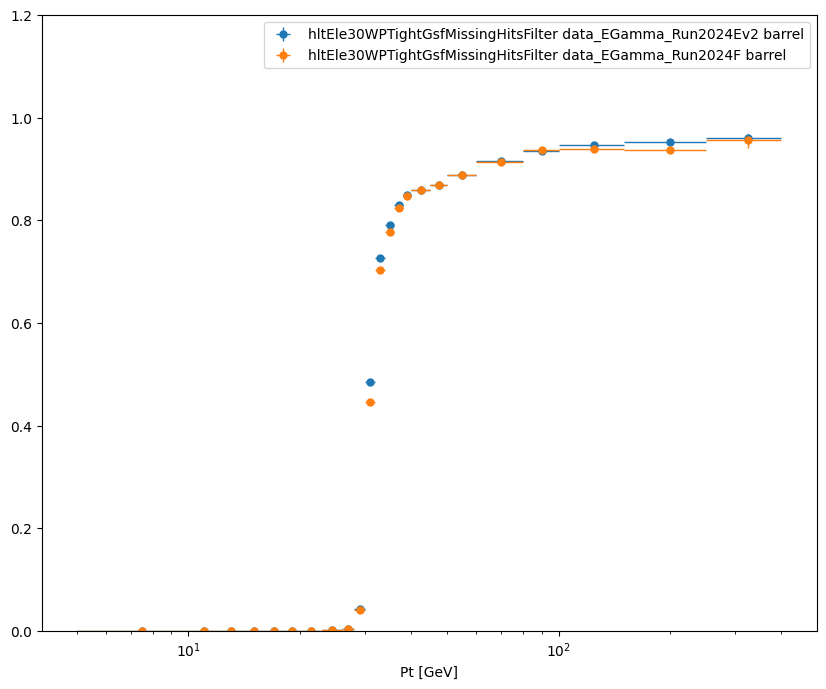

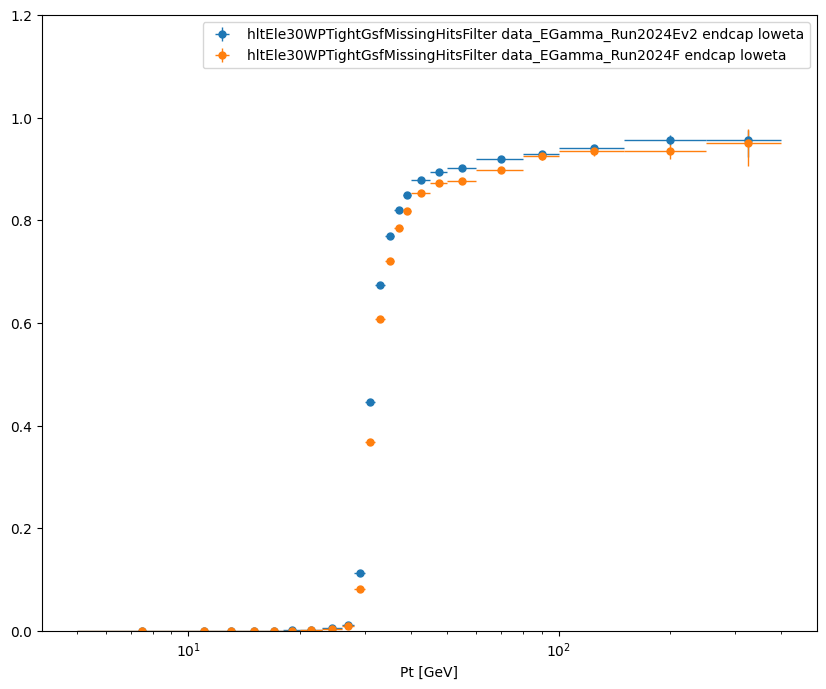

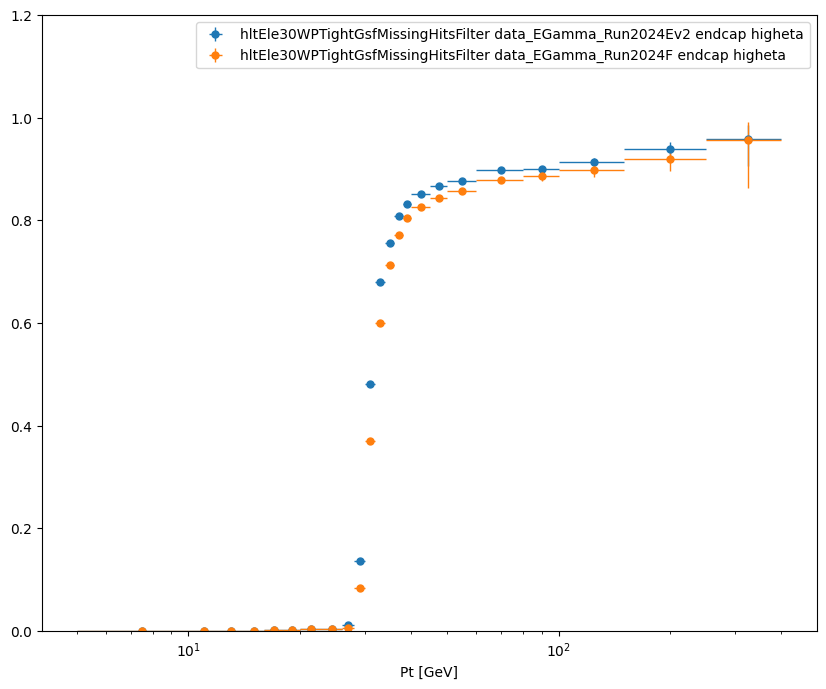

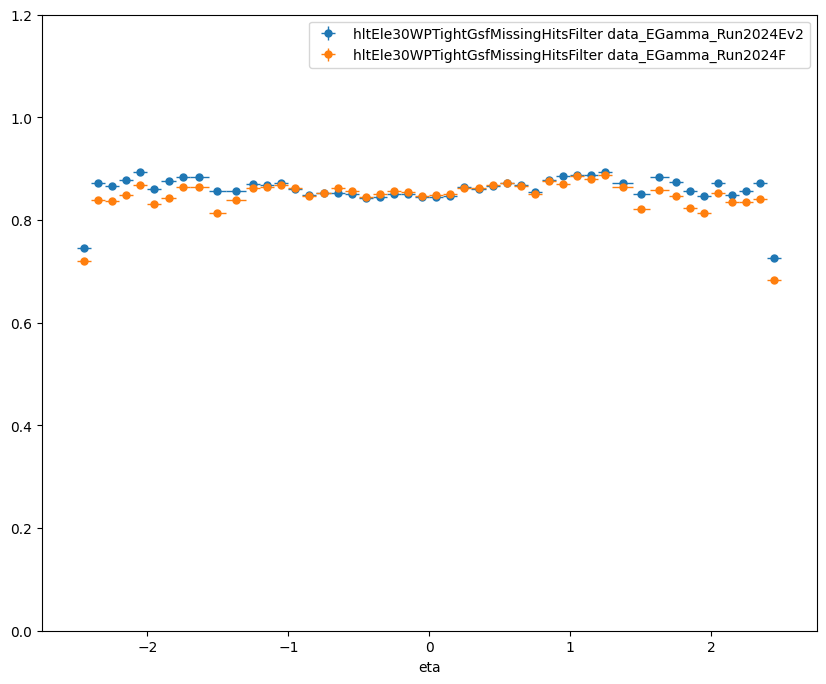

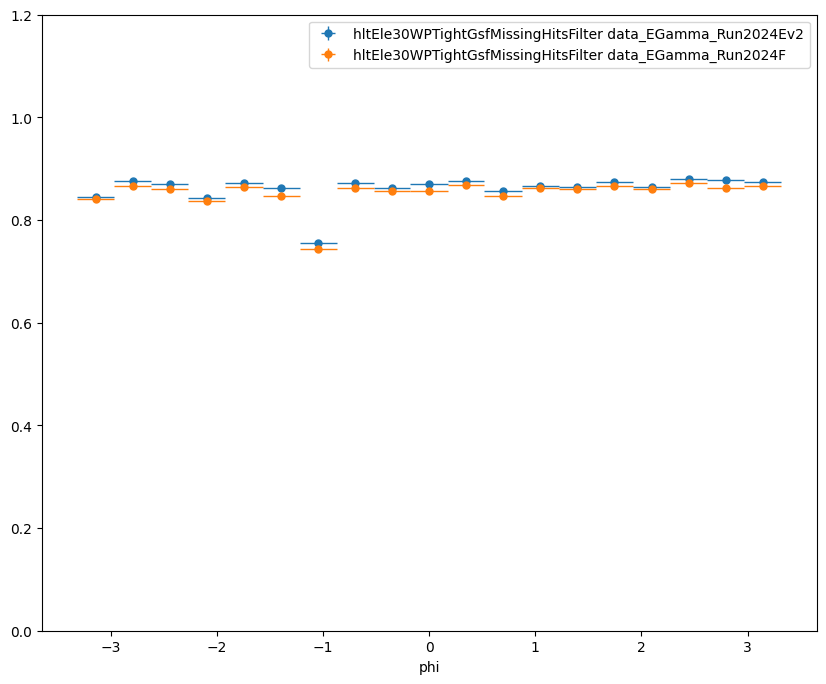

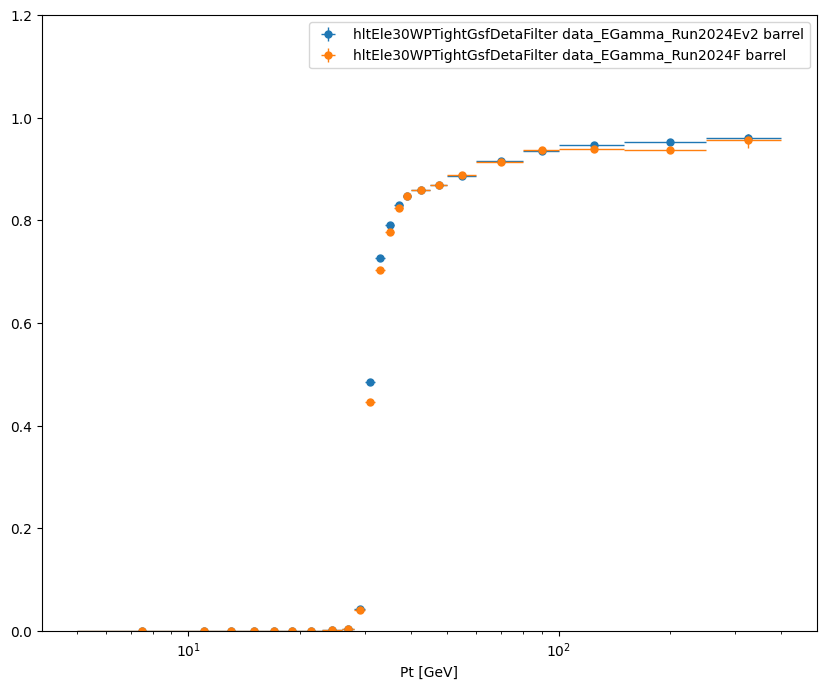

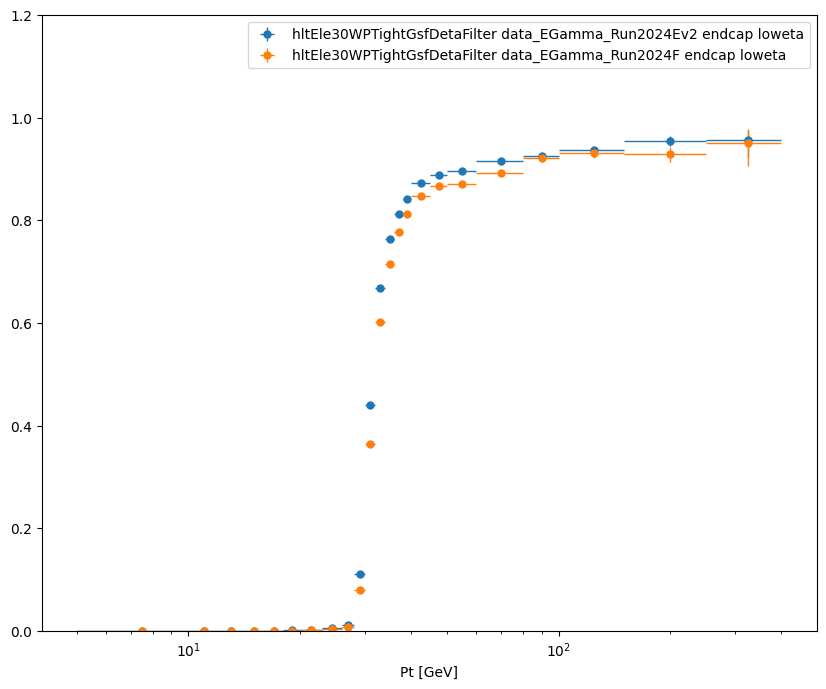

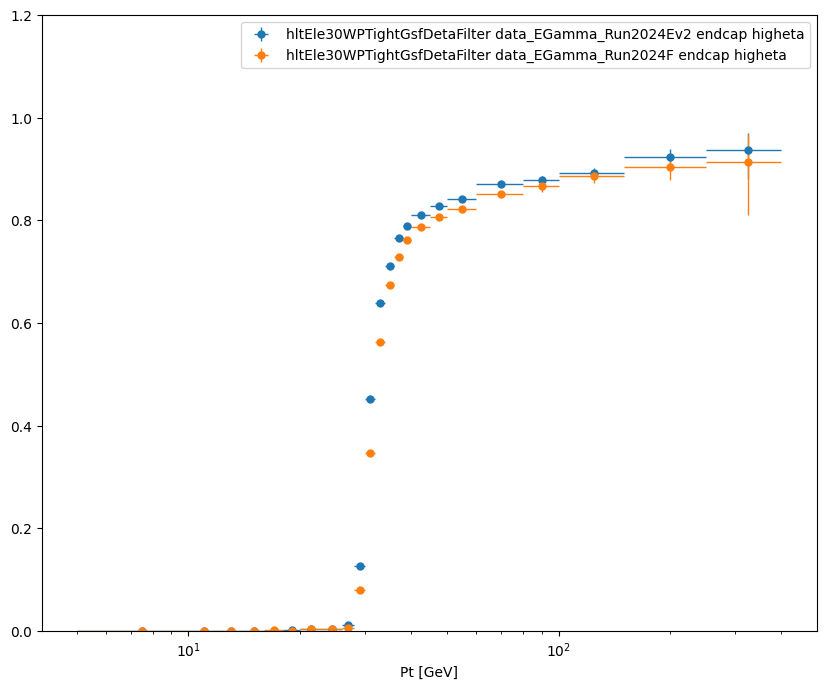

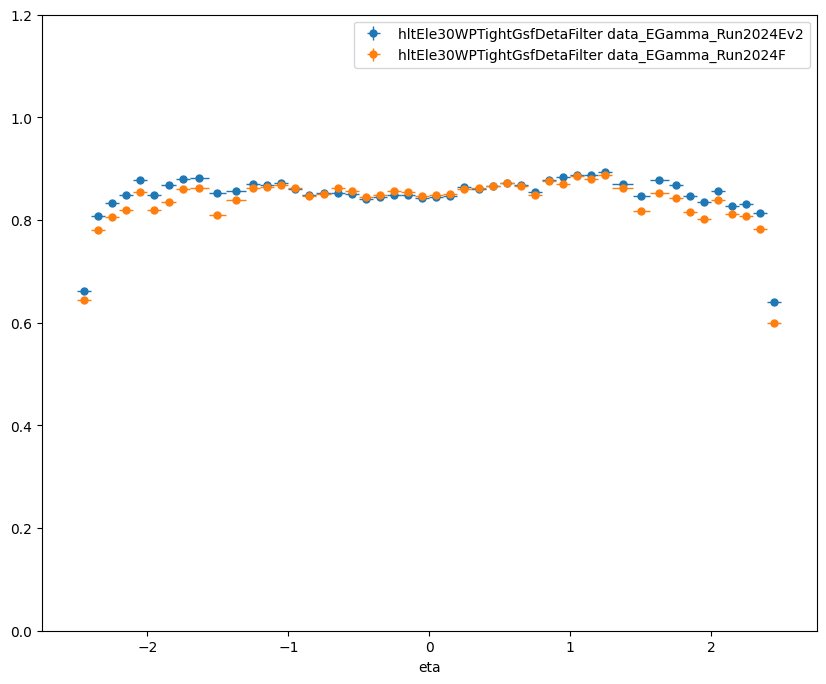

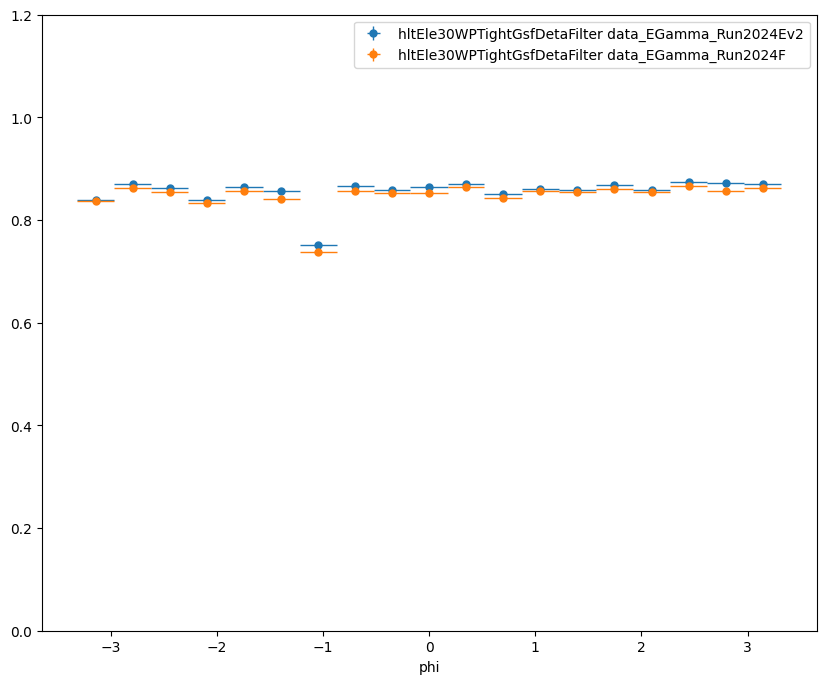

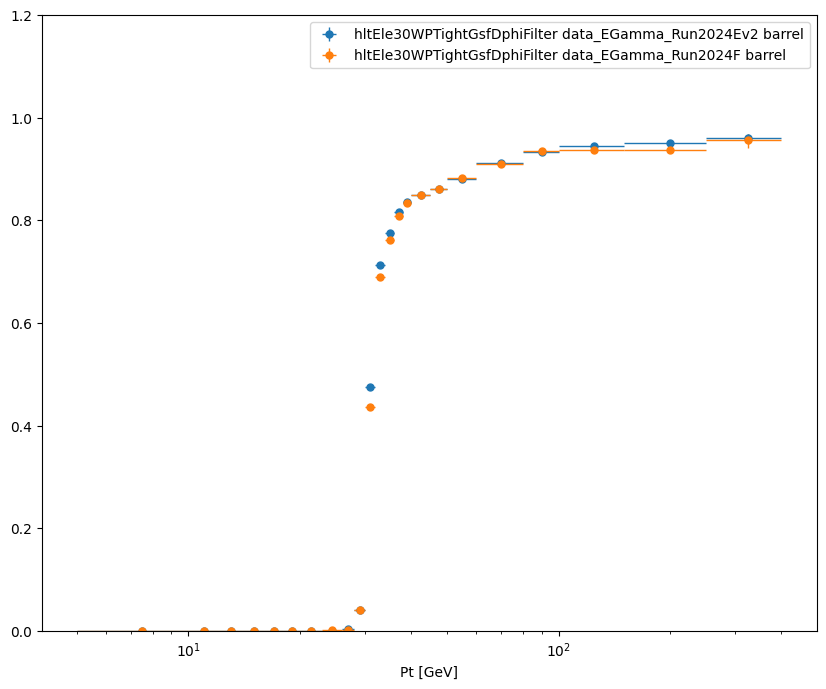

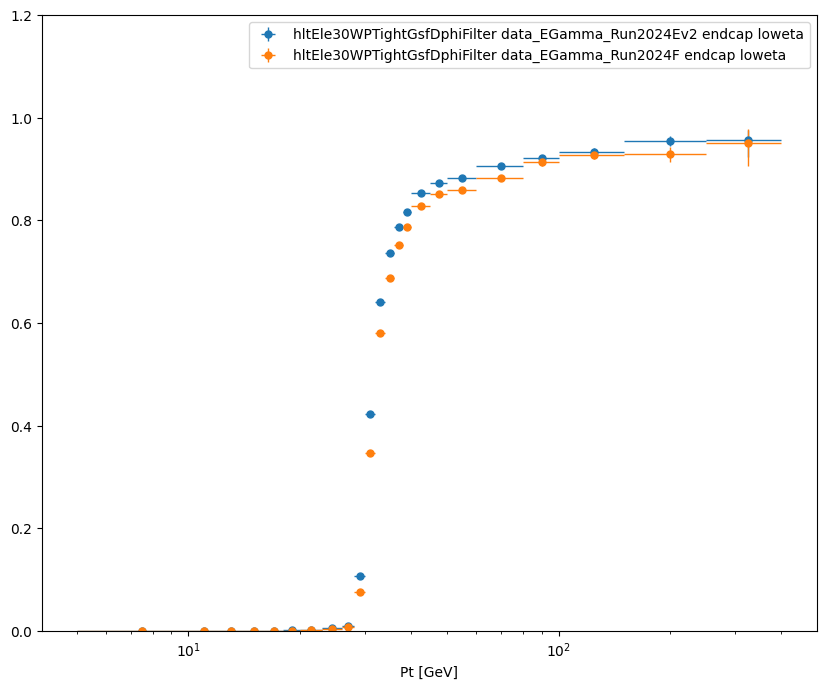

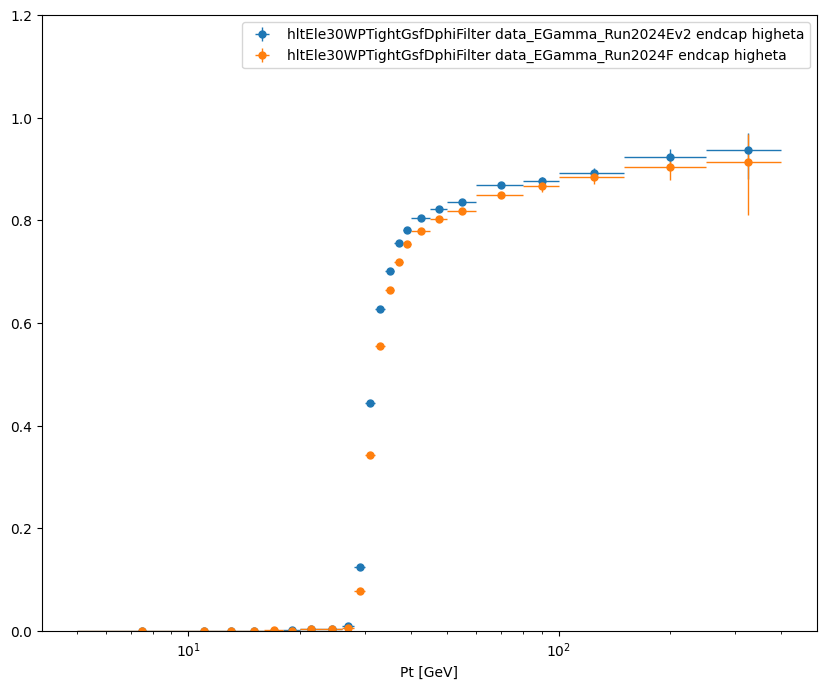

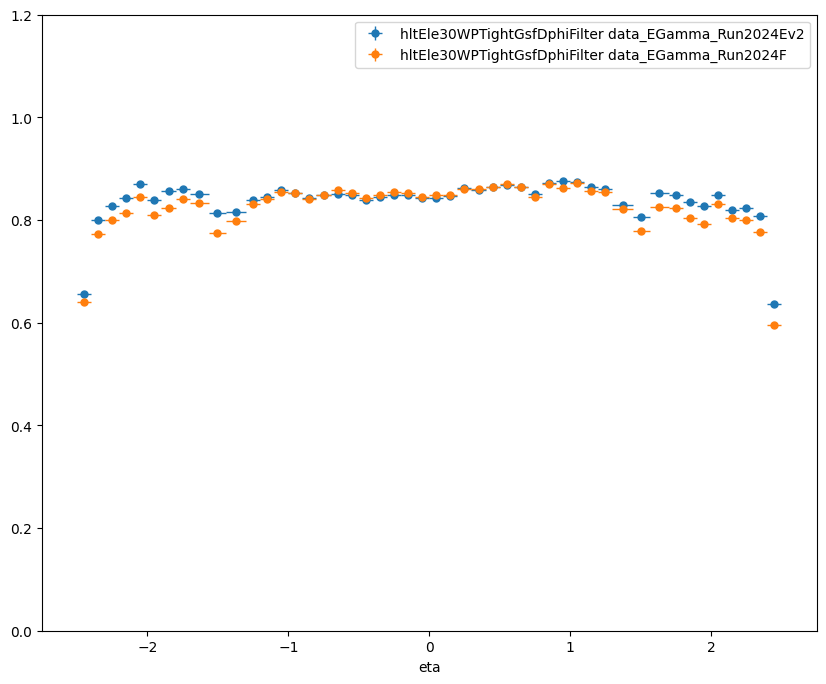

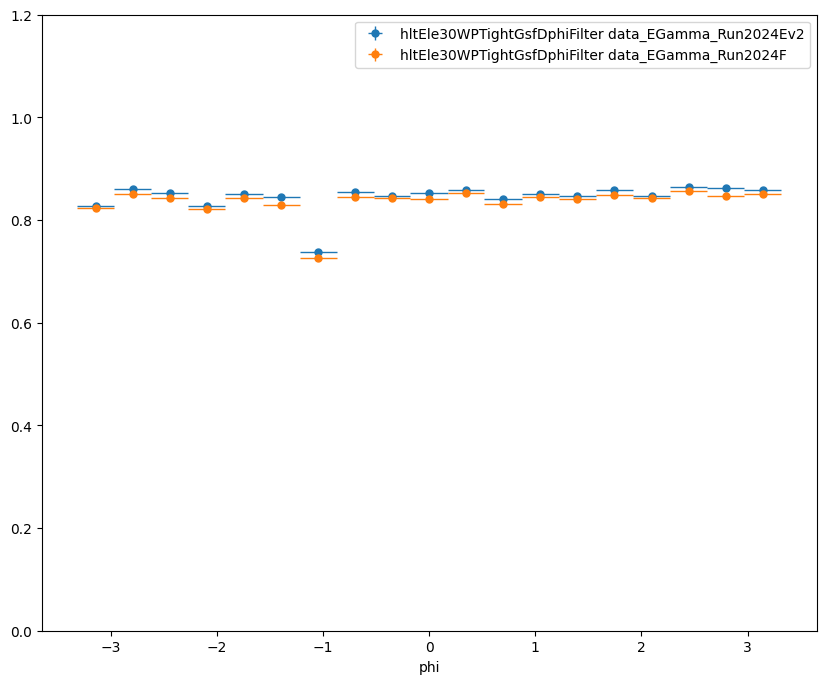

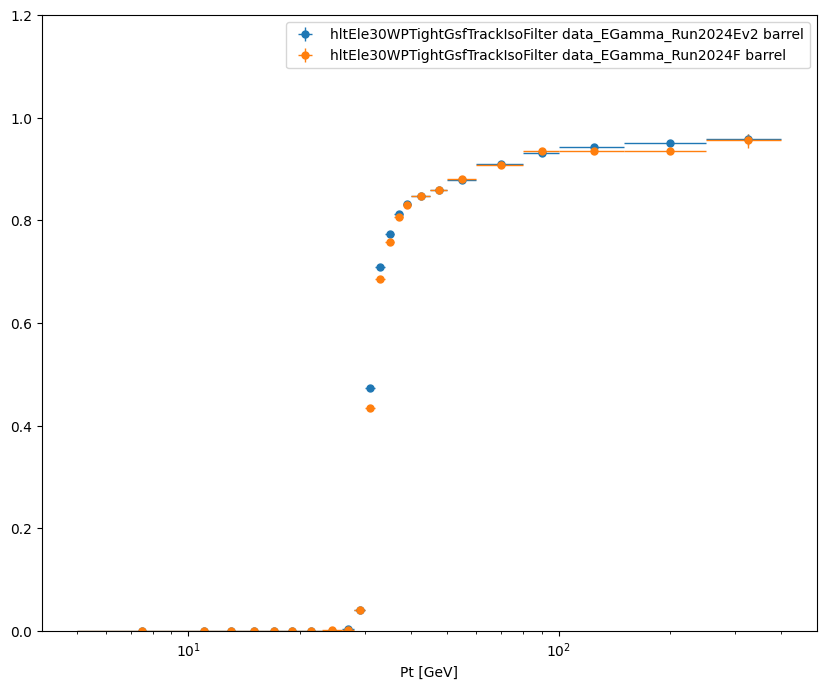

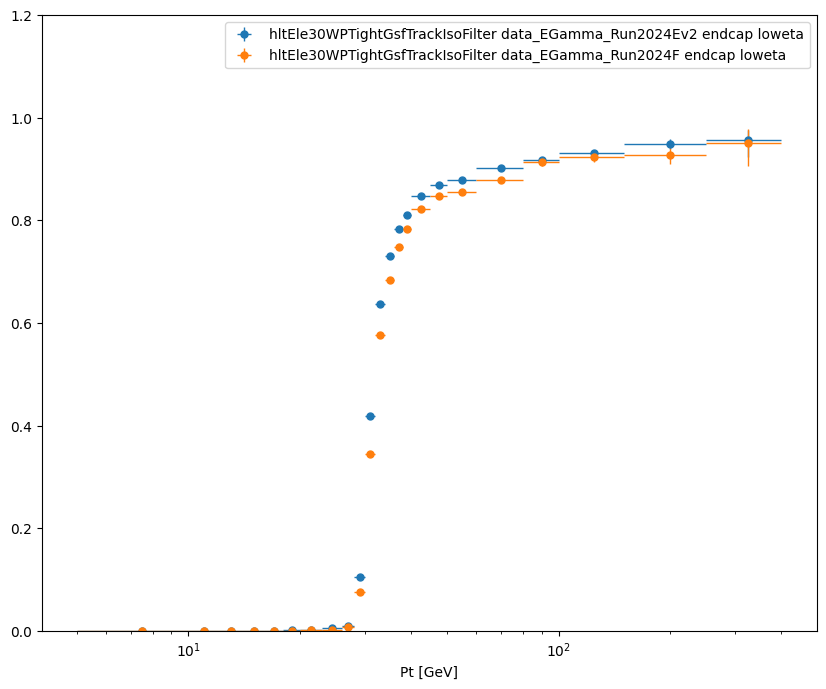

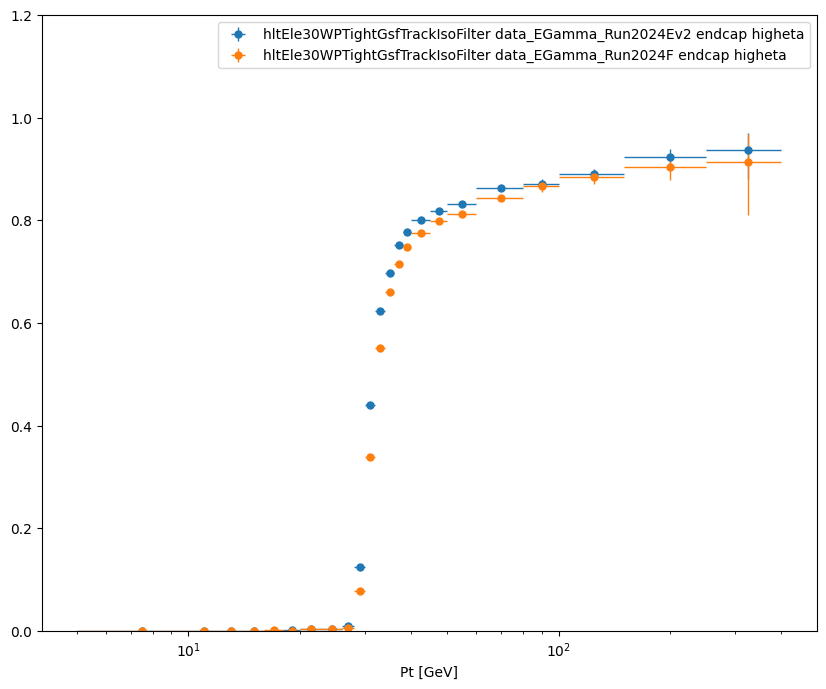

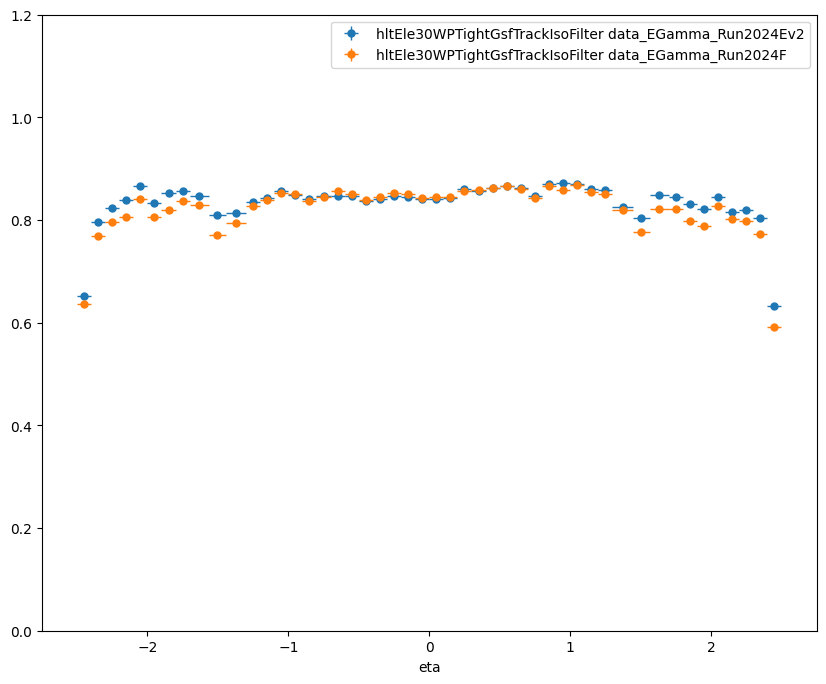

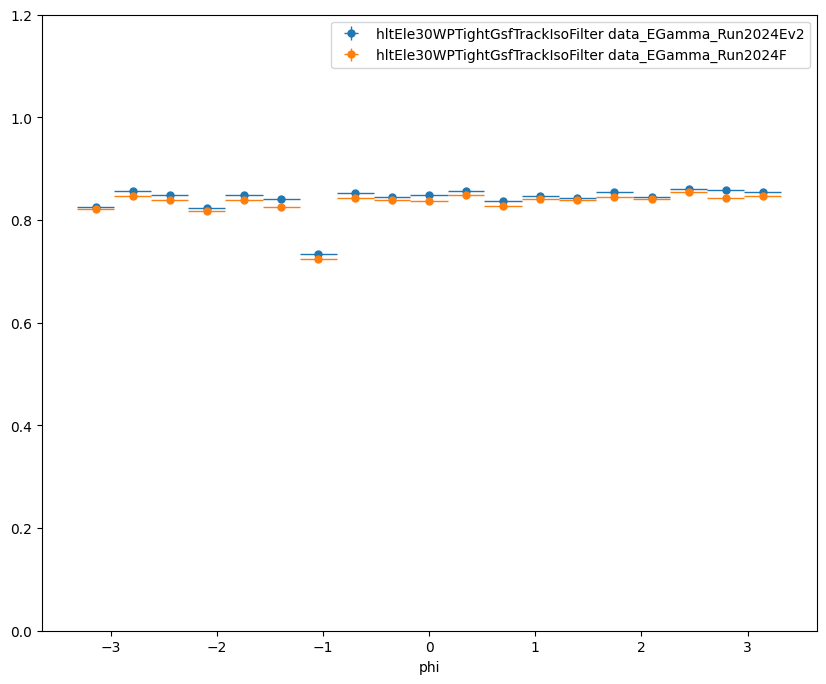

In [7]:
for filter in filters_to_check:
    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["barrel"]["passing"],
            hists["pt"]["barrel"]["failing"],
            label=f"{filter} {dataset} barrel",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["endcap_loweta"]["passing"],
            hists["pt"]["endcap_loweta"]["failing"],
            label=f"{filter} {dataset} endcap loweta",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["endcap_higheta"]["passing"],
            hists["pt"]["endcap_higheta"]["failing"],
            label=f"{filter} {dataset} endcap higheta",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["eta"]["entire"]["passing"],
            hists["eta"]["entire"]["failing"],
            label=f"{filter} {dataset}",
        )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["phi"]["entire"]["passing"],
            hists["phi"]["entire"]["failing"],
            label=f"{filter} {dataset}",
        )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()

In [ ]:
fileset = {
    "DY_NLO_2023preBPIX": {
        "files": {
            "root_files/Egamma0.root": "Events",
            "root_files/Egamma1.root": "Events",
        },
        "metadata": {"isMC": False, "pileupJSON": "jsonpog-integration/POG/LUM/2023_Summer23/puWeights.json.gz"},
    },
}

fileset_available, fileset_updates = preprocess(fileset, skip_bad_files=True, step_size=100_000)

In [ ]:
filters_to_check = ["HLT_Ele30_WPTight_Gsf", "HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_Leg1"]

In [ ]:
egamma_tnp.binning.set(
    "pt_bins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

to_compute = {}

tnp = ElectronTagNProbeFromNanoAOD(
    fileset,
    filters_to_check,
    use_sc_eta=True,
    probes_pt_cut=5,
    cutbased_id="cutBased >= 4",
    filterbit=[1, 4],
    require_event_to_pass_hlt_filter=True,
)

for filter in filters_to_check:
    to_compute[filter] = tnp.get_1d_pt_eta_phi_tnp_histograms(
        filter,
        vars=["el_pt", "el_eta", "el_phi"],
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=5,
        uproot_options={"allow_read_errors_with_report": False},
    )

dak.necessary_columns(to_compute)

In [ ]:
%%time

(out,) = dask.compute(to_compute)

In [ ]:
for filter in filters_to_check:
    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["barrel"]["passing"],
            hists["pt"]["barrel"]["failing"],
            label=f"{filter} {dataset} barrel",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["endcap_loweta"]["passing"],
            hists["pt"]["endcap_loweta"]["failing"],
            label=f"{filter} {dataset} endcap loweta",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["endcap_higheta"]["passing"],
            hists["pt"]["endcap_higheta"]["failing"],
            label=f"{filter} {dataset} endcap higheta",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["eta"]["entire"]["passing"],
            hists["eta"]["entire"]["failing"],
            label=f"{filter} {dataset}",
        )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["phi"]["entire"]["passing"],
            hists["phi"]["entire"]["failing"],
            label=f"{filter} {dataset}",
        )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()